In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from tqdm.autonotebook import tqdm
from joblib import Parallel, delayed
import umap
import pandas as pd

/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/tqdm/autonotebook/__init__.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)


In [3]:
from avgn.utils.paths import DATA_DIR, most_recent_subdirectory, ensure_dir

In [4]:
DATASET_ID = 'BIRD_DB_Toxostoma_redivivum'

In [5]:
from avgn.utils.hparams import HParams
from avgn.dataset import DataSet

In [6]:
from avgn.signalprocessing.create_spectrogram_dataset import prepare_wav, create_label_df, get_row_audio

### create dataset

In [7]:
hparams = HParams(
    num_mel_bins = 32,
    mel_lower_edge_hertz=500,
    mel_upper_edge_hertz=10000,
    butter_lowcut = 500,
    butter_highcut = 10000,
    ref_level_db = 20,
    min_level_db = -25,
    mask_spec = True,
    win_length_ms = 10,
    hop_length_ms = 2,
    mask_spec_kwargs = {"spec_thresh": 0.9, "offset": 1e-10}
)

In [8]:
# create a dataset object
dataset = DataSet(DATASET_ID, hparams = hparams)

In [9]:
# dataset.data_files = {i:dataset.data_files[i] for i in list(dataset.data_files.keys())[:5]}

In [10]:
dataset.sample_json

OrderedDict([('TrackName', 'tSMM0212-39'),
             ('type_of_device', 'single microphone'),
             ('configuration', 'MOC2012'),
             ('microphone',
              'Sennheiser omnidirectional with Telinga parabolic reflector'),
             ('recorder', 'Marantz PMD650'),
             ('sample_rate', 44.0),
             ('Recordist_first_name', 'Martin'),
             ('Recordist_last_name', 'Cody'),
             ('recording_date', '2012-02-10_00-00-00'),
             ('recording_time', '10:10:00'),
             ('recording_length', '00:02:23'),
             ('Audio_file',
              'http://taylor0.biology.ucla.edu/birdDBQuery/Files/Tracks/2012/Feb/TRK39-2-12.WAV'),
             ('SubjectName', 'CATH-TLR3'),
             ('subject_importance', 'Primary subject'),
             ('quality_rating', 4.0),
             ('Species_short_name', 'CATH'),
             ('Subject_species', 'California Thrasher'),
             ('sex', 'Unkown sex'),
             ('age_class', '

In [11]:
len(dataset.data_files)

93

#### Create dataset based upon JSON

In [12]:
from joblib import Parallel, delayed
n_jobs = -1; verbosity = 10

In [13]:
with Parallel(n_jobs=n_jobs, verbose=verbosity) as parallel:
    syllable_dfs = parallel(
        delayed(create_label_df)(
            dataset.data_files[key].data,
            hparams=dataset.hparams,
            labels_to_retain=["labels"],
            unit="syllables",
            dict_features_to_retain = ['subject_importance'],
            key = key,
        )
        for key in tqdm(dataset.data_files.keys())
    )
syllable_df = pd.concat(syllable_dfs)
len(syllable_df)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    8.5s
[Parallel(n_jobs=-1)]: Done  13 tasks      | elapsed:    8.5s
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    8.6s
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:    8.7s
[Parallel(n_jobs=-1)]: Done  56 out of  93 | elapsed:    8.8s remaining:    5.8s
[Parallel(n_jobs=-1)]: Done  66 out of  93 | elapsed:    8.9s remaining:    3.6s
[Parallel(n_jobs=-1)]: Done  76 out of  93 | elapsed:    8.9s remaining:    2.0s
[Parallel(n_jobs=-1)]: Done  86 out of  93 | elapsed:    8.9s remaining:    0.7s
[Parallel(n_jobs=-1)]: Done  93 out of  93 | elapsed:    8.9s finished


15546

In [14]:
syllable_df[:3]

start_time   end_time labels       indv  indvi subject_importance  \
0   10.219057  10.650069    apa  CATH-TLR3      0    Primary subject   
1   10.927989  11.403752    apa  CATH-TLR3      0    Primary subject   
2   11.864023  11.901707    axk  CATH-TLR3      0    Primary subject   

                          key  
0  2012-02-10_10-10-00-000000  
1  2012-02-10_10-10-00-000000  
2  2012-02-10_10-10-00-000000

### get audio for dataset

In [1]:
with Parallel(n_jobs=n_jobs, verbose=verbosity) as parallel:
    syllable_dfs = parallel(
        delayed(get_row_audio)(
            syllable_df[syllable_df.key == key], 
            dataset.data_files[key].data['wav_loc'], 
            dataset.hparams
        )
        for key in tqdm(syllable_df.key.unique())
    )
syllable_df = pd.concat(syllable_dfs)
len(syllable_df)

NameError: name 'Parallel' is not defined

In [16]:
df_mask  = np.array([len(i) > 0 for i in tqdm(syllable_df.audio.values)])

In [17]:
syllable_df = syllable_df[np.array(df_mask)]

In [18]:
syllable_df[:3]

start_time   end_time labels       indv  indvi subject_importance  \
0   10.219057  10.650069    apa  CATH-TLR3      0    Primary subject   
1   10.927989  11.403752    apa  CATH-TLR3      0    Primary subject   
2   11.864023  11.901707    axk  CATH-TLR3      0    Primary subject   

                          key  \
0  2012-02-10_10-10-00-000000   
1  2012-02-10_10-10-00-000000   
2  2012-02-10_10-10-00-000000   

                                               audio   rate  
0  [-0.0022280442703339707, -0.001889398079154199...  44100  
1  [-0.0017386628103927828, -0.001223714299915131...  44100  
2  [0.0051619203262459525, 0.0073353070857139204,...  44100

In [19]:
sylls = syllable_df.audio.values

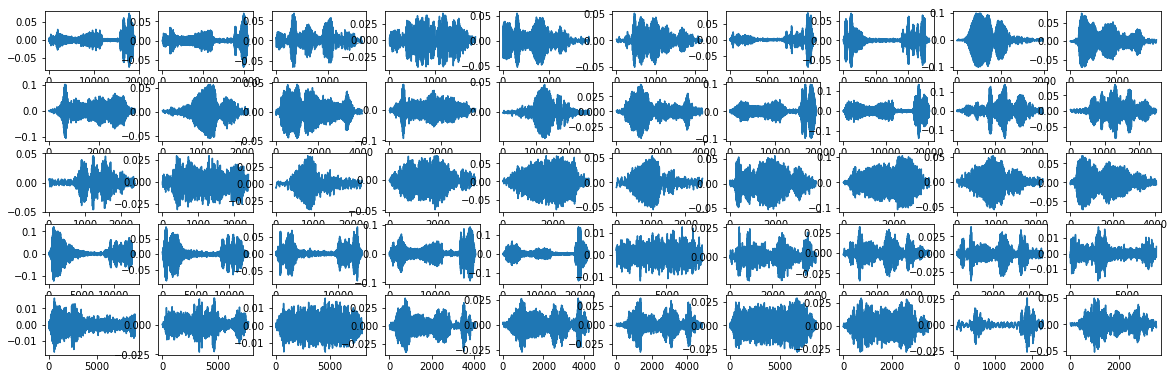

In [20]:
nrows = 5
ncols = 10
zoom = 2
fig, axs = plt.subplots(ncols=ncols, nrows = nrows,figsize = (ncols*zoom, nrows+zoom/1.5))
for i, syll in tqdm(enumerate(sylls), total = nrows*ncols):
    ax = axs.flatten()[i]
    ax.plot(syll)
    if i == nrows*ncols -1:
        break

In [21]:
syllable_df['audio'] = [i/np.max(i) for i in syllable_df.audio.values]

### Create spectrograms

In [22]:
from avgn.visualization.spectrogram import draw_spec_set
from avgn.signalprocessing.create_spectrogram_dataset import make_spec, mask_spec, log_resize_spec, pad_spectrogram

In [23]:
syllables_wav = syllable_df.audio.values
syllables_rate = syllable_df.rate.values

In [24]:
with Parallel(n_jobs=n_jobs, verbose=verbosity) as parallel:
    # create spectrograms
    syllables_spec = parallel(
        delayed(make_spec)(
            syllable,
            rate,
            hparams=dataset.hparams,
            mel_matrix=dataset.mel_matrix,
            use_mel=True,
            use_tensorflow=False,
        )
        for syllable, rate in tqdm(
            zip(syllables_wav, syllables_rate),
            total=len(syllables_rate),
            desc="getting syllable spectrograms",
            leave=False,
        )
    )

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0482s.) Setting batch_size=8.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  13 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.1562s.) Setting batch_size=20.
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    0.2s
/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 304 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]:

[Parallel(n_jobs=-1)]: Done 15546 out of 15546 | elapsed:    6.9s finished


### Rescale spectrogram
- using log rescaling

In [25]:
log_scaling_factor = 4

In [26]:
with Parallel(n_jobs=n_jobs, verbose=verbosity) as parallel:
    syllables_spec = parallel(
        delayed(log_resize_spec)(spec, scaling_factor=log_scaling_factor)
        for spec in tqdm(syllables_spec, desc="scaling spectrograms", leave=False)
    )

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0086s.) Setting batch_size=46.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  19 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.1771s.) Setting batch_size=102.
[Parallel(n_jobs=-1)]: Done 508 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 1106 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 1984 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 3514 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 5044 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 6778 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 8512 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 10450 tasks      | elapsed:    1.6s


[Parallel(n_jobs=-1)]: Done 12388 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done 15546 out of 15546 | elapsed:    2.0s finished


(25.0, 10) (320, 800) 25.0 32 800


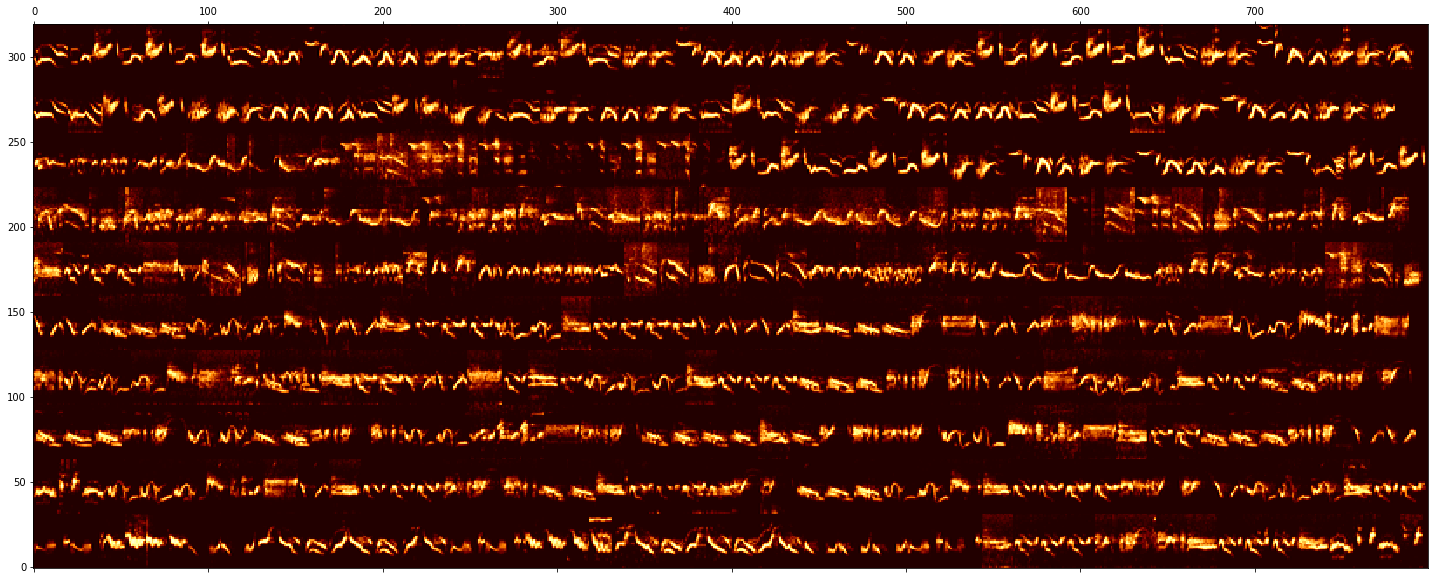

In [27]:
draw_spec_set(syllables_spec, zoom=1, maxrows=10, colsize=25)

### Pad spectrograms

In [1]:
syll_lens = [np.shape(i)[1] for i in syllables_spec]
pad_length = np.max(syll_lens)

NameError: name 'syllables_spec' is not defined

In [ ]:
syllable_df[:3]

In [ ]:
import seaborn as sns

/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


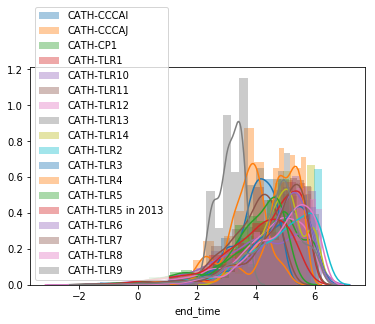

In [31]:
for indv in np.unique(syllable_df.indv):
    sns.distplot(np.log(syllable_df[syllable_df.indv==indv]["end_time"]), label=indv)
plt.legend()

In [32]:
with Parallel(n_jobs=n_jobs, verbose=verbosity) as parallel:

    syllables_spec = parallel(
        delayed(pad_spectrogram)(spec, pad_length)
        for spec in tqdm(
            syllables_spec, desc="padding spectrograms", leave=False
        )
    )

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0390s.) Setting batch_size=10.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  19 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  39 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0864s.) Setting batch_size=46.
[Parallel(n_jobs=-1)]: Done 148 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 278 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0699s.) Setting batch_size=262.
[Parallel(n_jobs=-1)]: Done 696 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 1350 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 4416 tasks      | elapsed:    1.0s


[Parallel(n_jobs=-1)]: Done 15546 out of 15546 | elapsed:    2.0s finished


(25.0, 10) (320, 800) 25.0 32 800


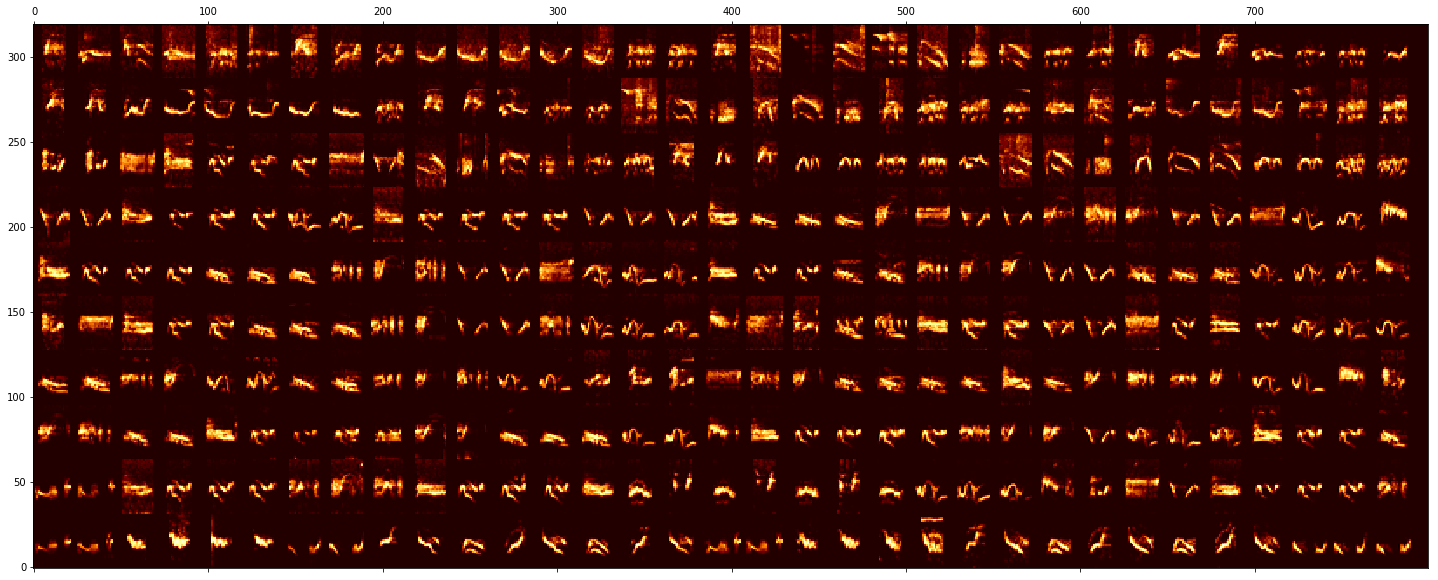

In [33]:
draw_spec_set(syllables_spec, zoom=1, maxrows=10, colsize=25)

In [34]:
np.shape(syllables_spec)

(15546, 32, 24)

In [35]:
syllable_df['spectrogram'] = syllables_spec

In [36]:
syllable_df[:3]

start_time   end_time labels       indv  indvi subject_importance  \
0   10.219057  10.650069    apa  CATH-TLR3      0    Primary subject   
1   10.927989  11.403752    apa  CATH-TLR3      0    Primary subject   
2   11.864023  11.901707    axk  CATH-TLR3      0    Primary subject   

                          key  \
0  2012-02-10_10-10-00-000000   
1  2012-02-10_10-10-00-000000   
2  2012-02-10_10-10-00-000000   

                                               audio   rate  \
0  [-0.029489595094457068, -0.0250073955299598, -...  44100   
1  [-0.024406587501860595, -0.017177965709986937,...  44100   
2  [0.07585475000128172, 0.10779280771544165, 0.1...  44100   

                                         spectrogram  
0  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...  
1  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...  
2  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...

### view syllables per indv

In [37]:
syllable_df.indv.unique()

array(['CATH-TLR3', 'CATH-TLR10', 'CATH-CCCAJ', 'CATH-TLR8', 'CATH-CCCAI',
       'CATH-TLR7', 'CATH-TLR9', 'CATH-CP1', 'CATH-TLR1', 'CATH-TLR6',
       'CATH-TLR11', 'CATH-TLR5', 'CATH-TLR4', 'CATH-TLR14', 'CATH-TLR12',
       'CATH-TLR2', 'CATH-TLR5 in 2013', 'CATH-TLR13'], dtype=object)

CATH-CCCAI 220
(50.0, 14) (224, 800) 25.0 32 800


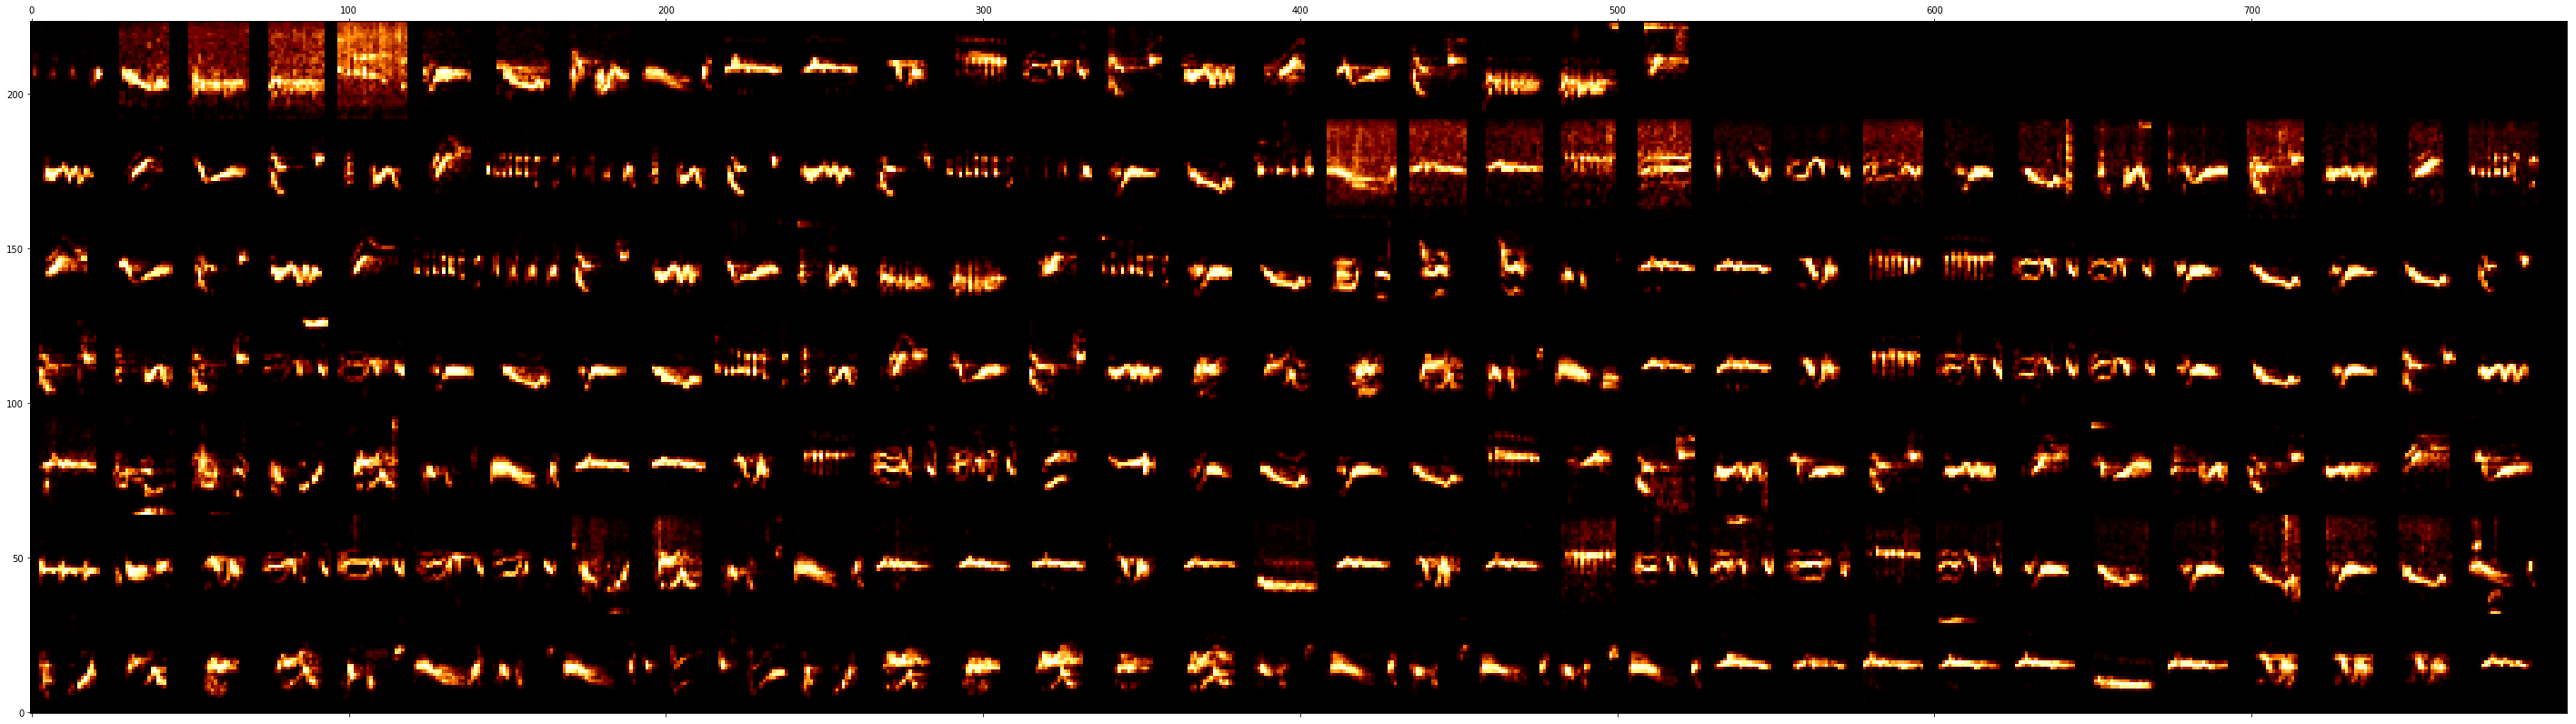

CATH-CCCAJ 107
(50.0, 8) (128, 800) 25.0 32 800


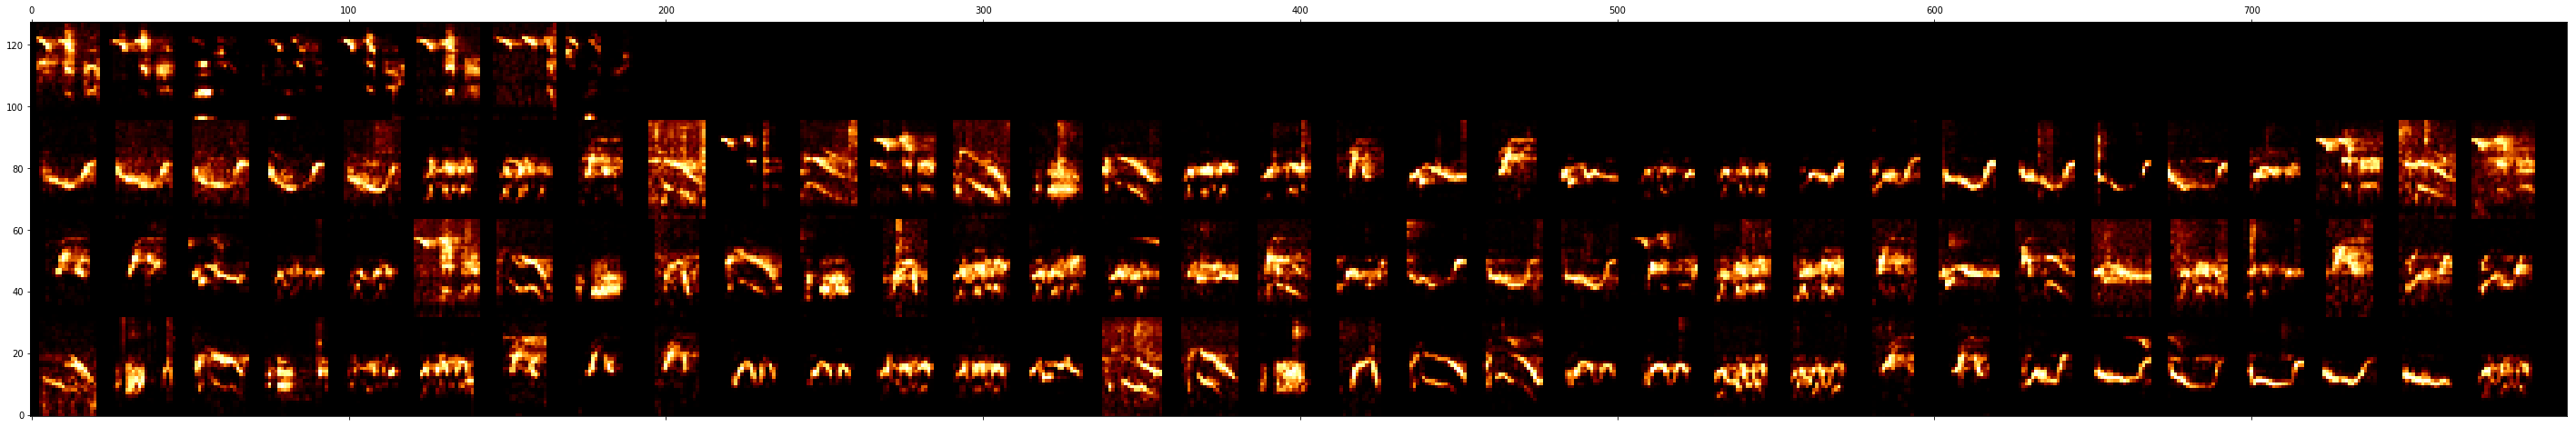

CATH-CP1 2881
(50.0, 32) (512, 800) 25.0 32 800


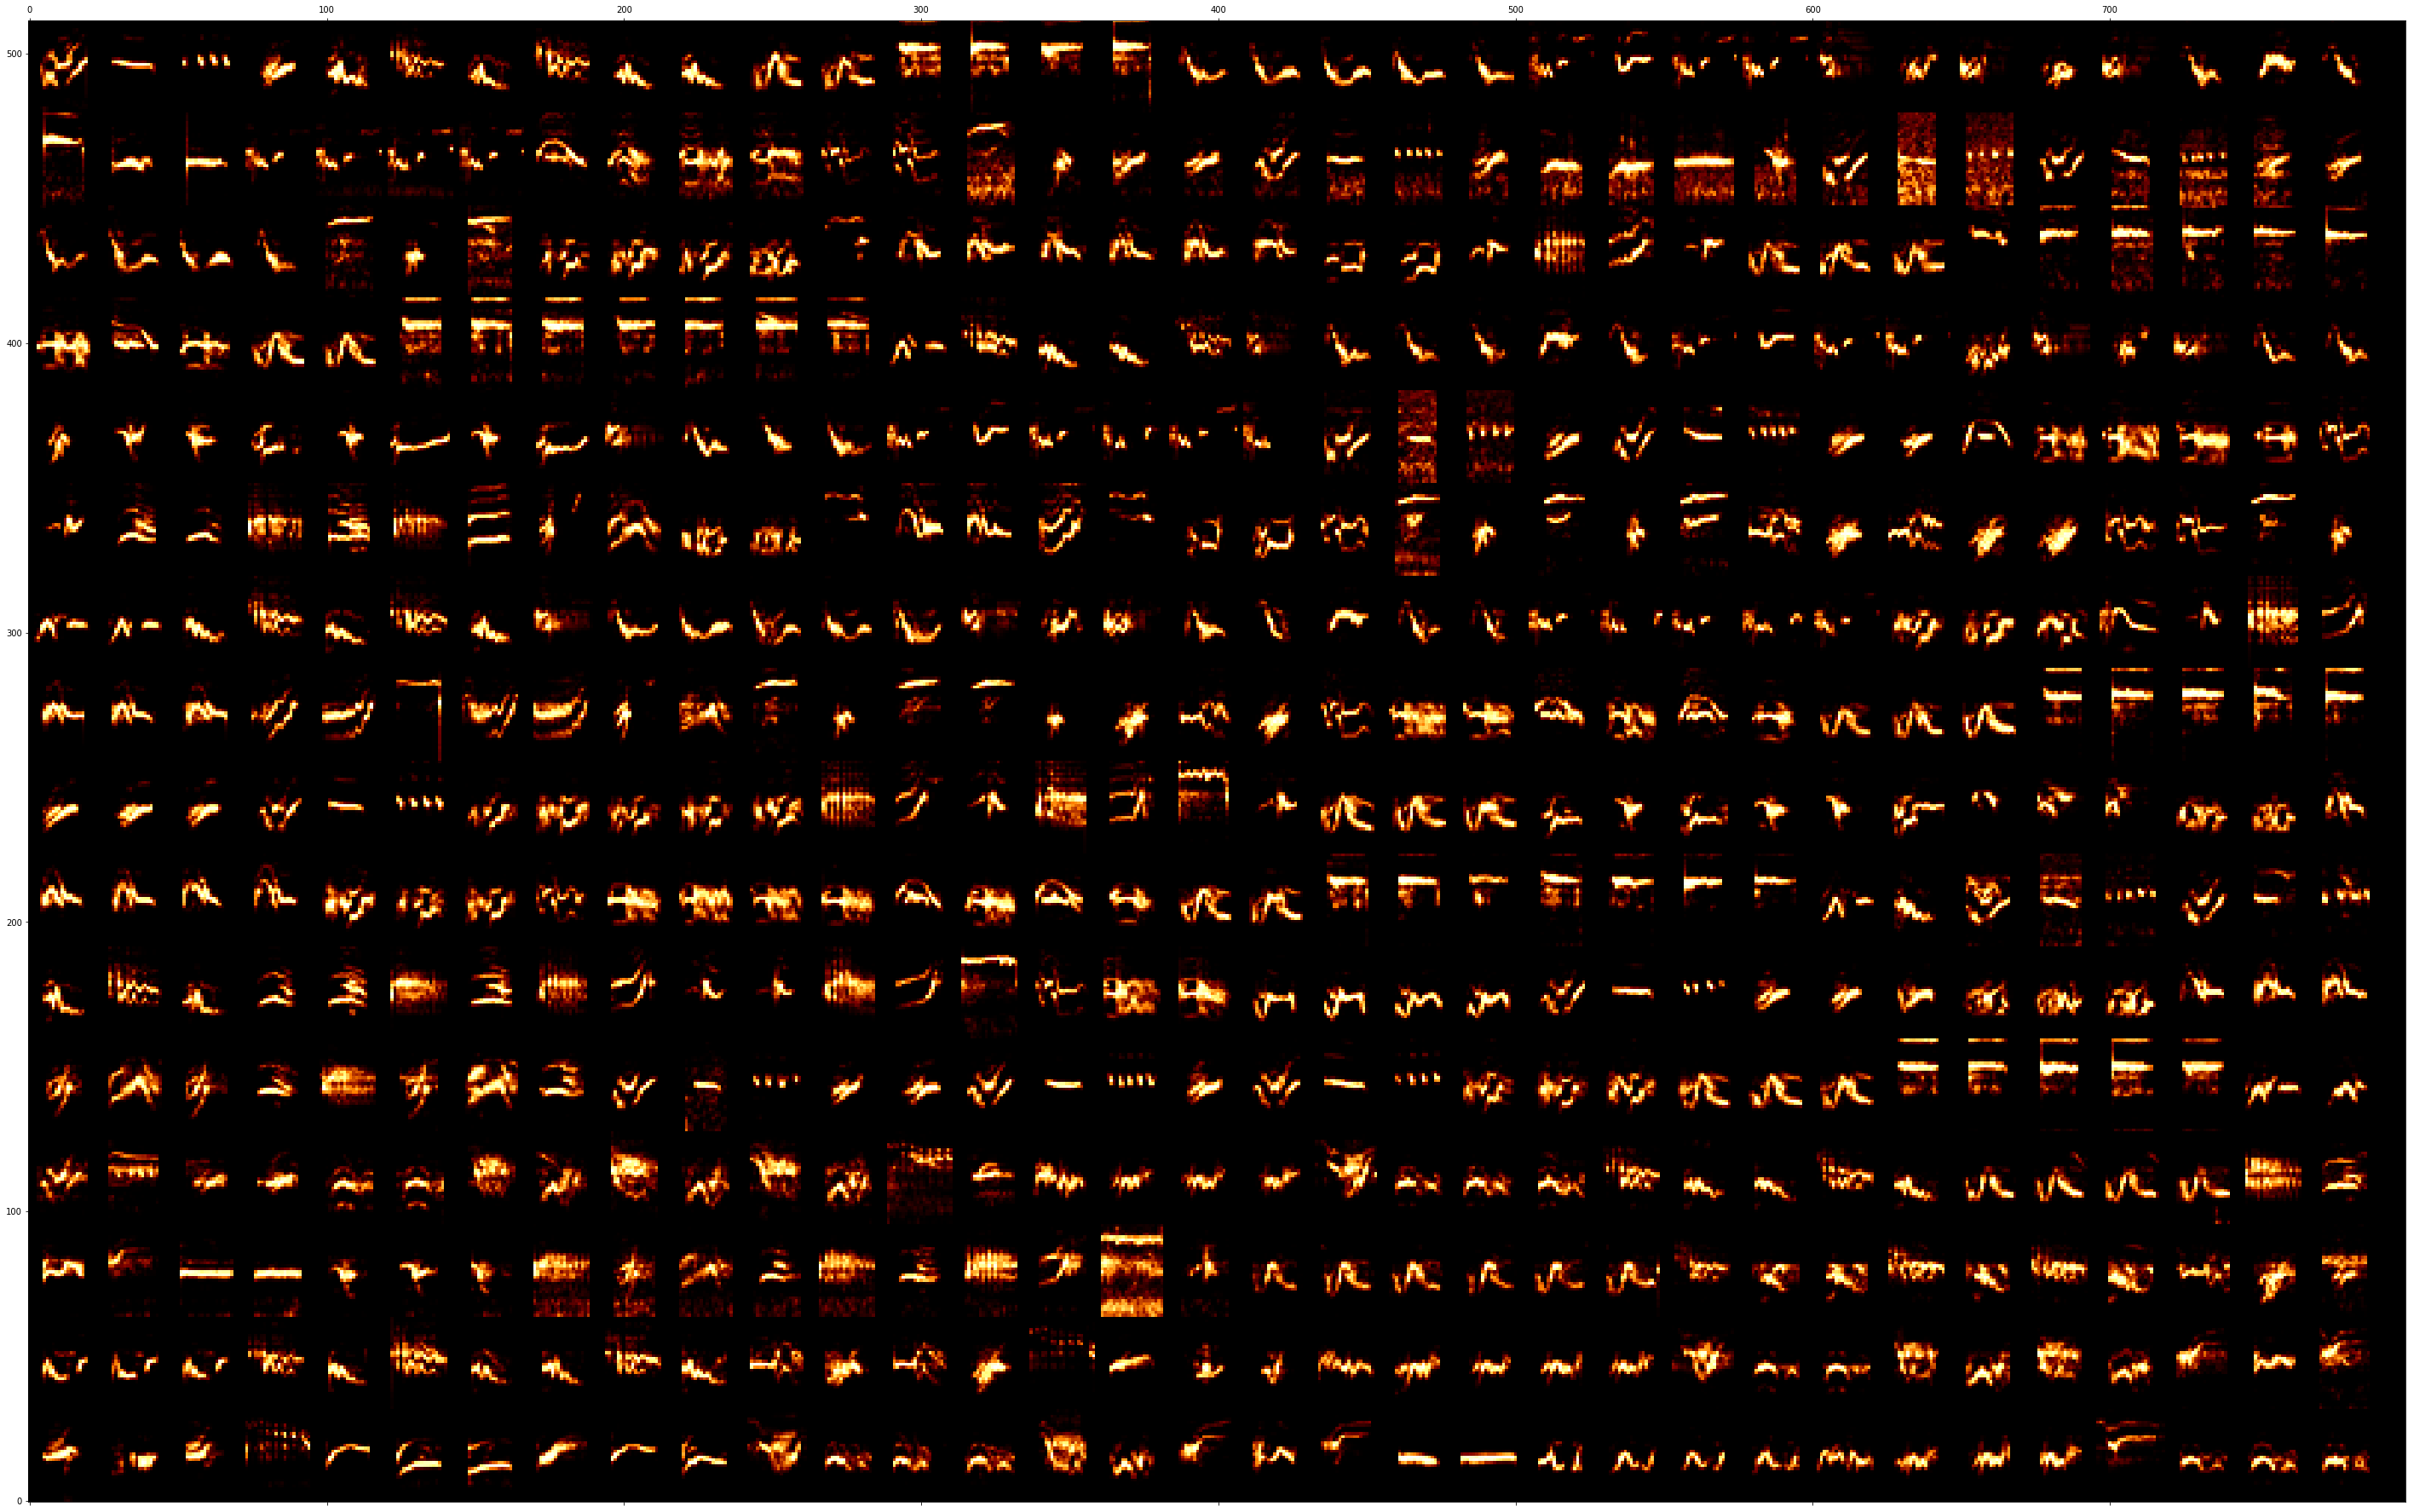

CATH-TLR1 1404
(50.0, 32) (512, 800) 25.0 32 800


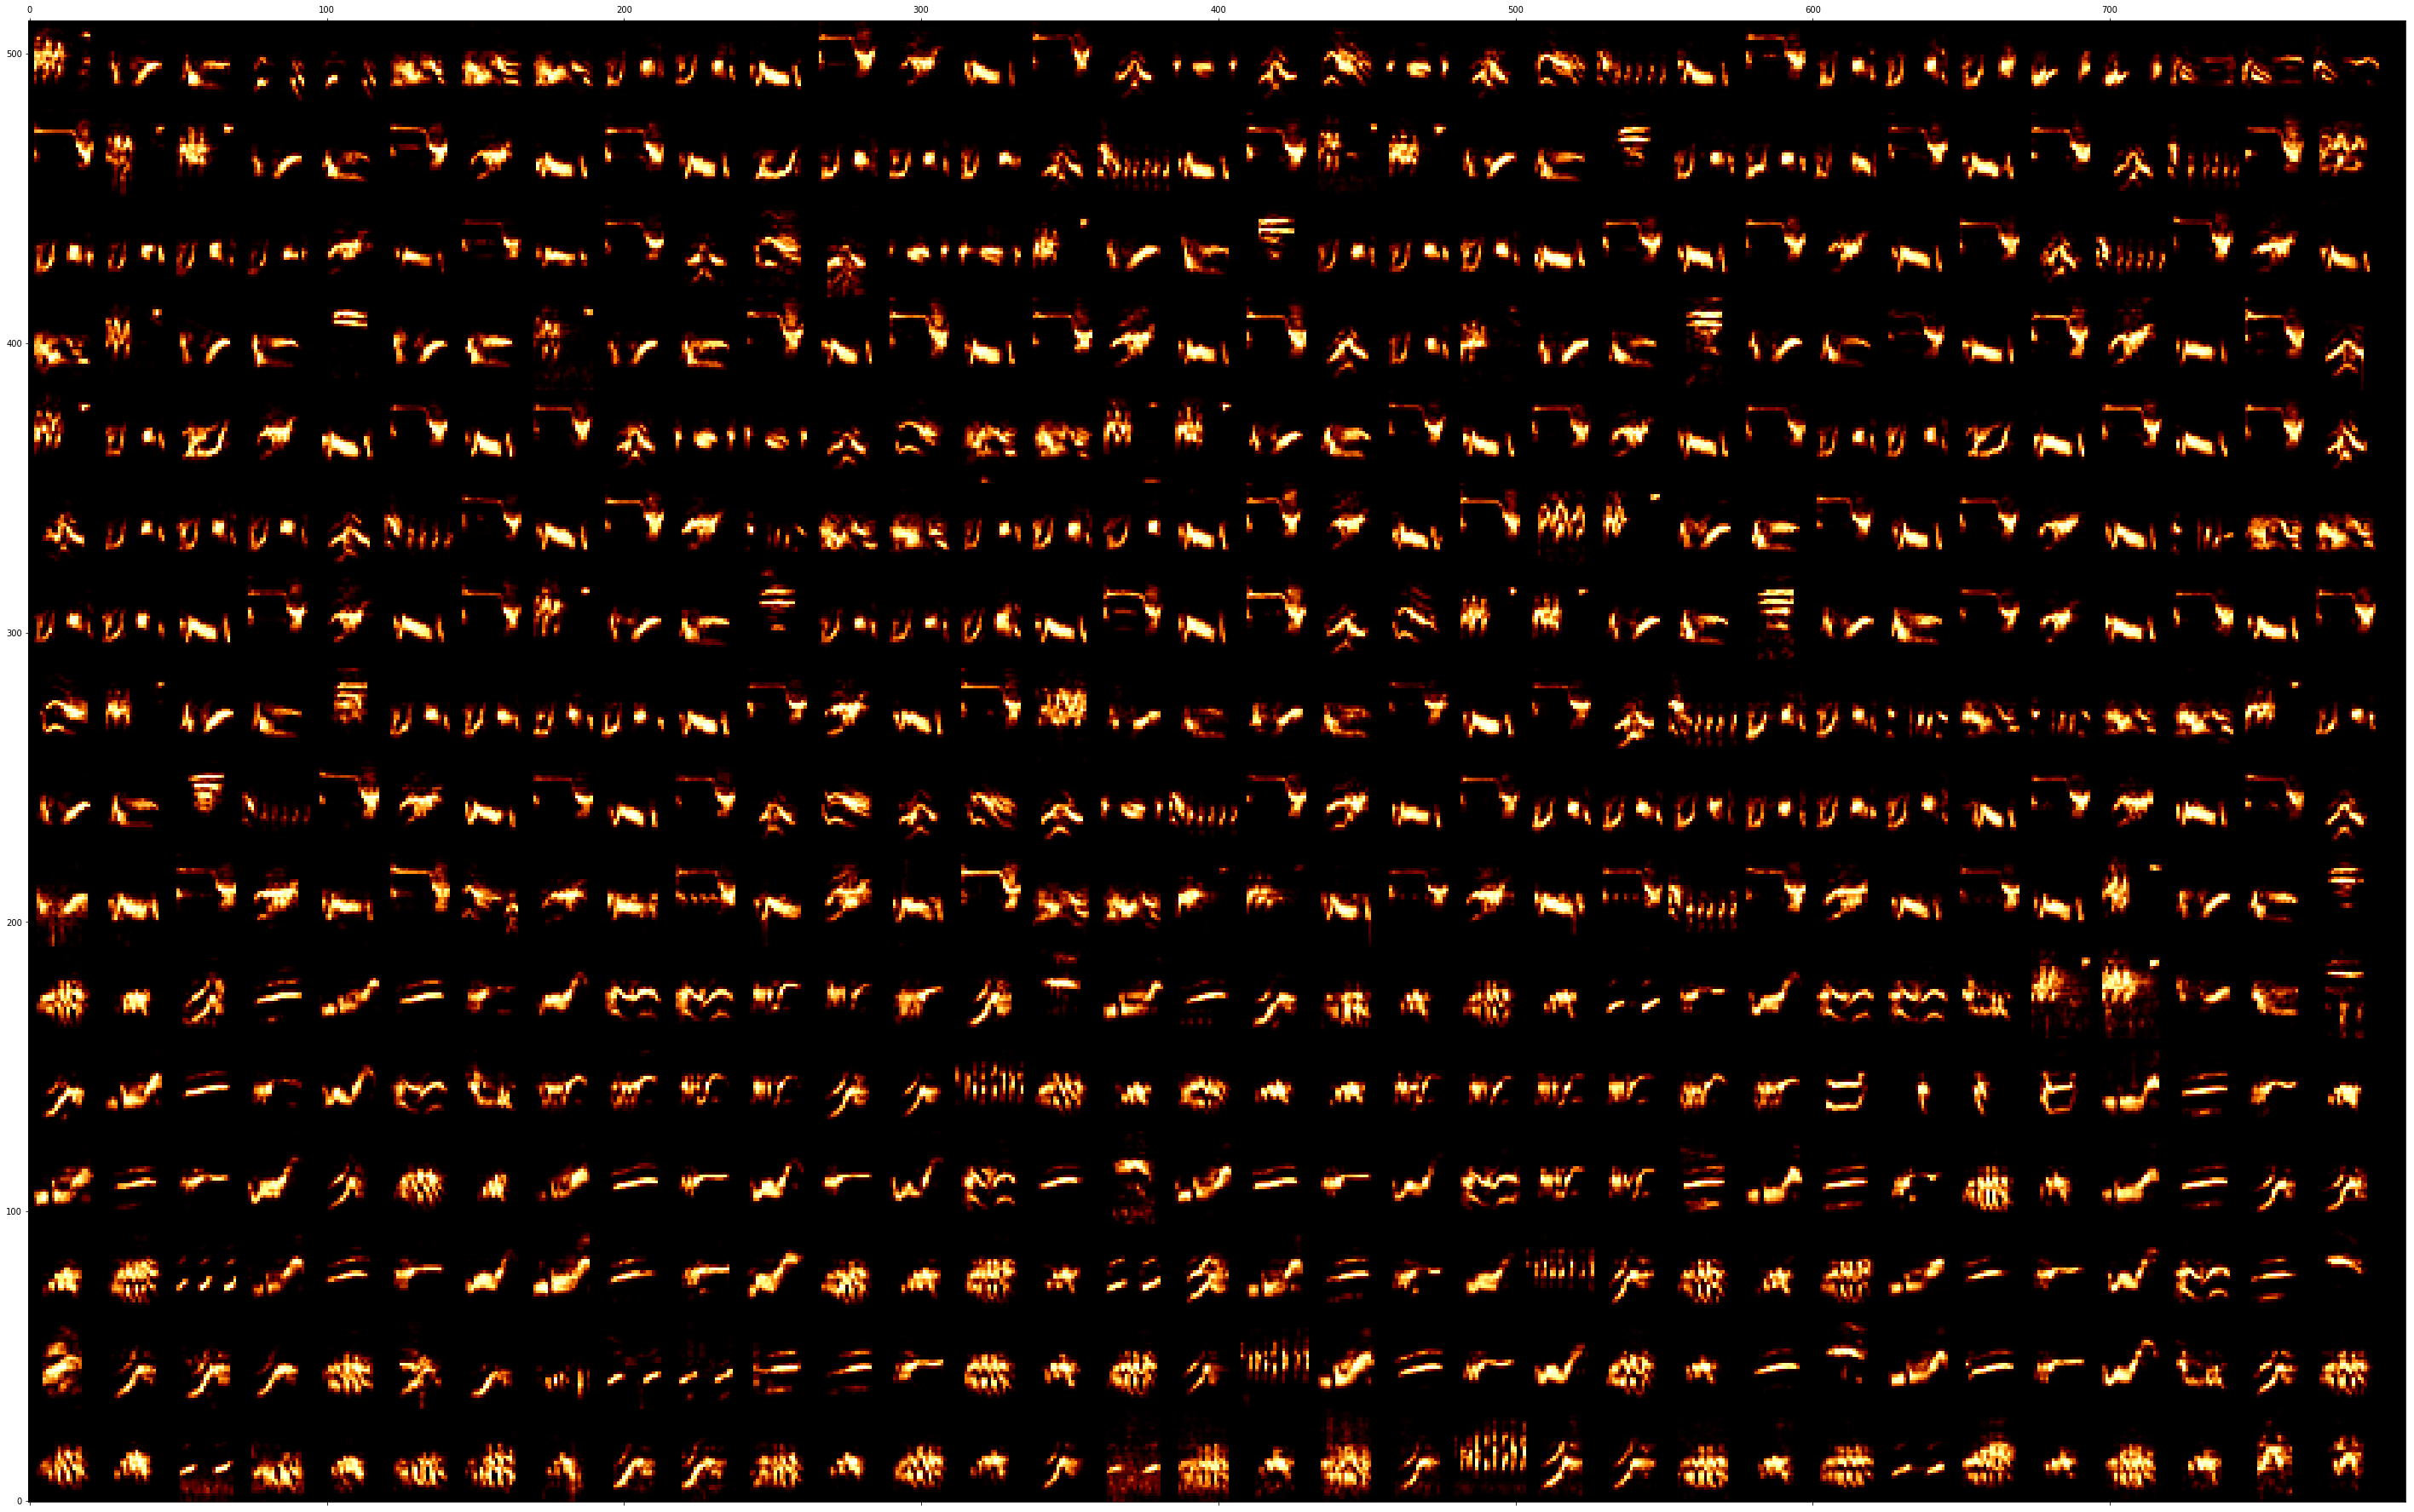

CATH-TLR10 701
(50.0, 32) (512, 800) 25.0 32 800


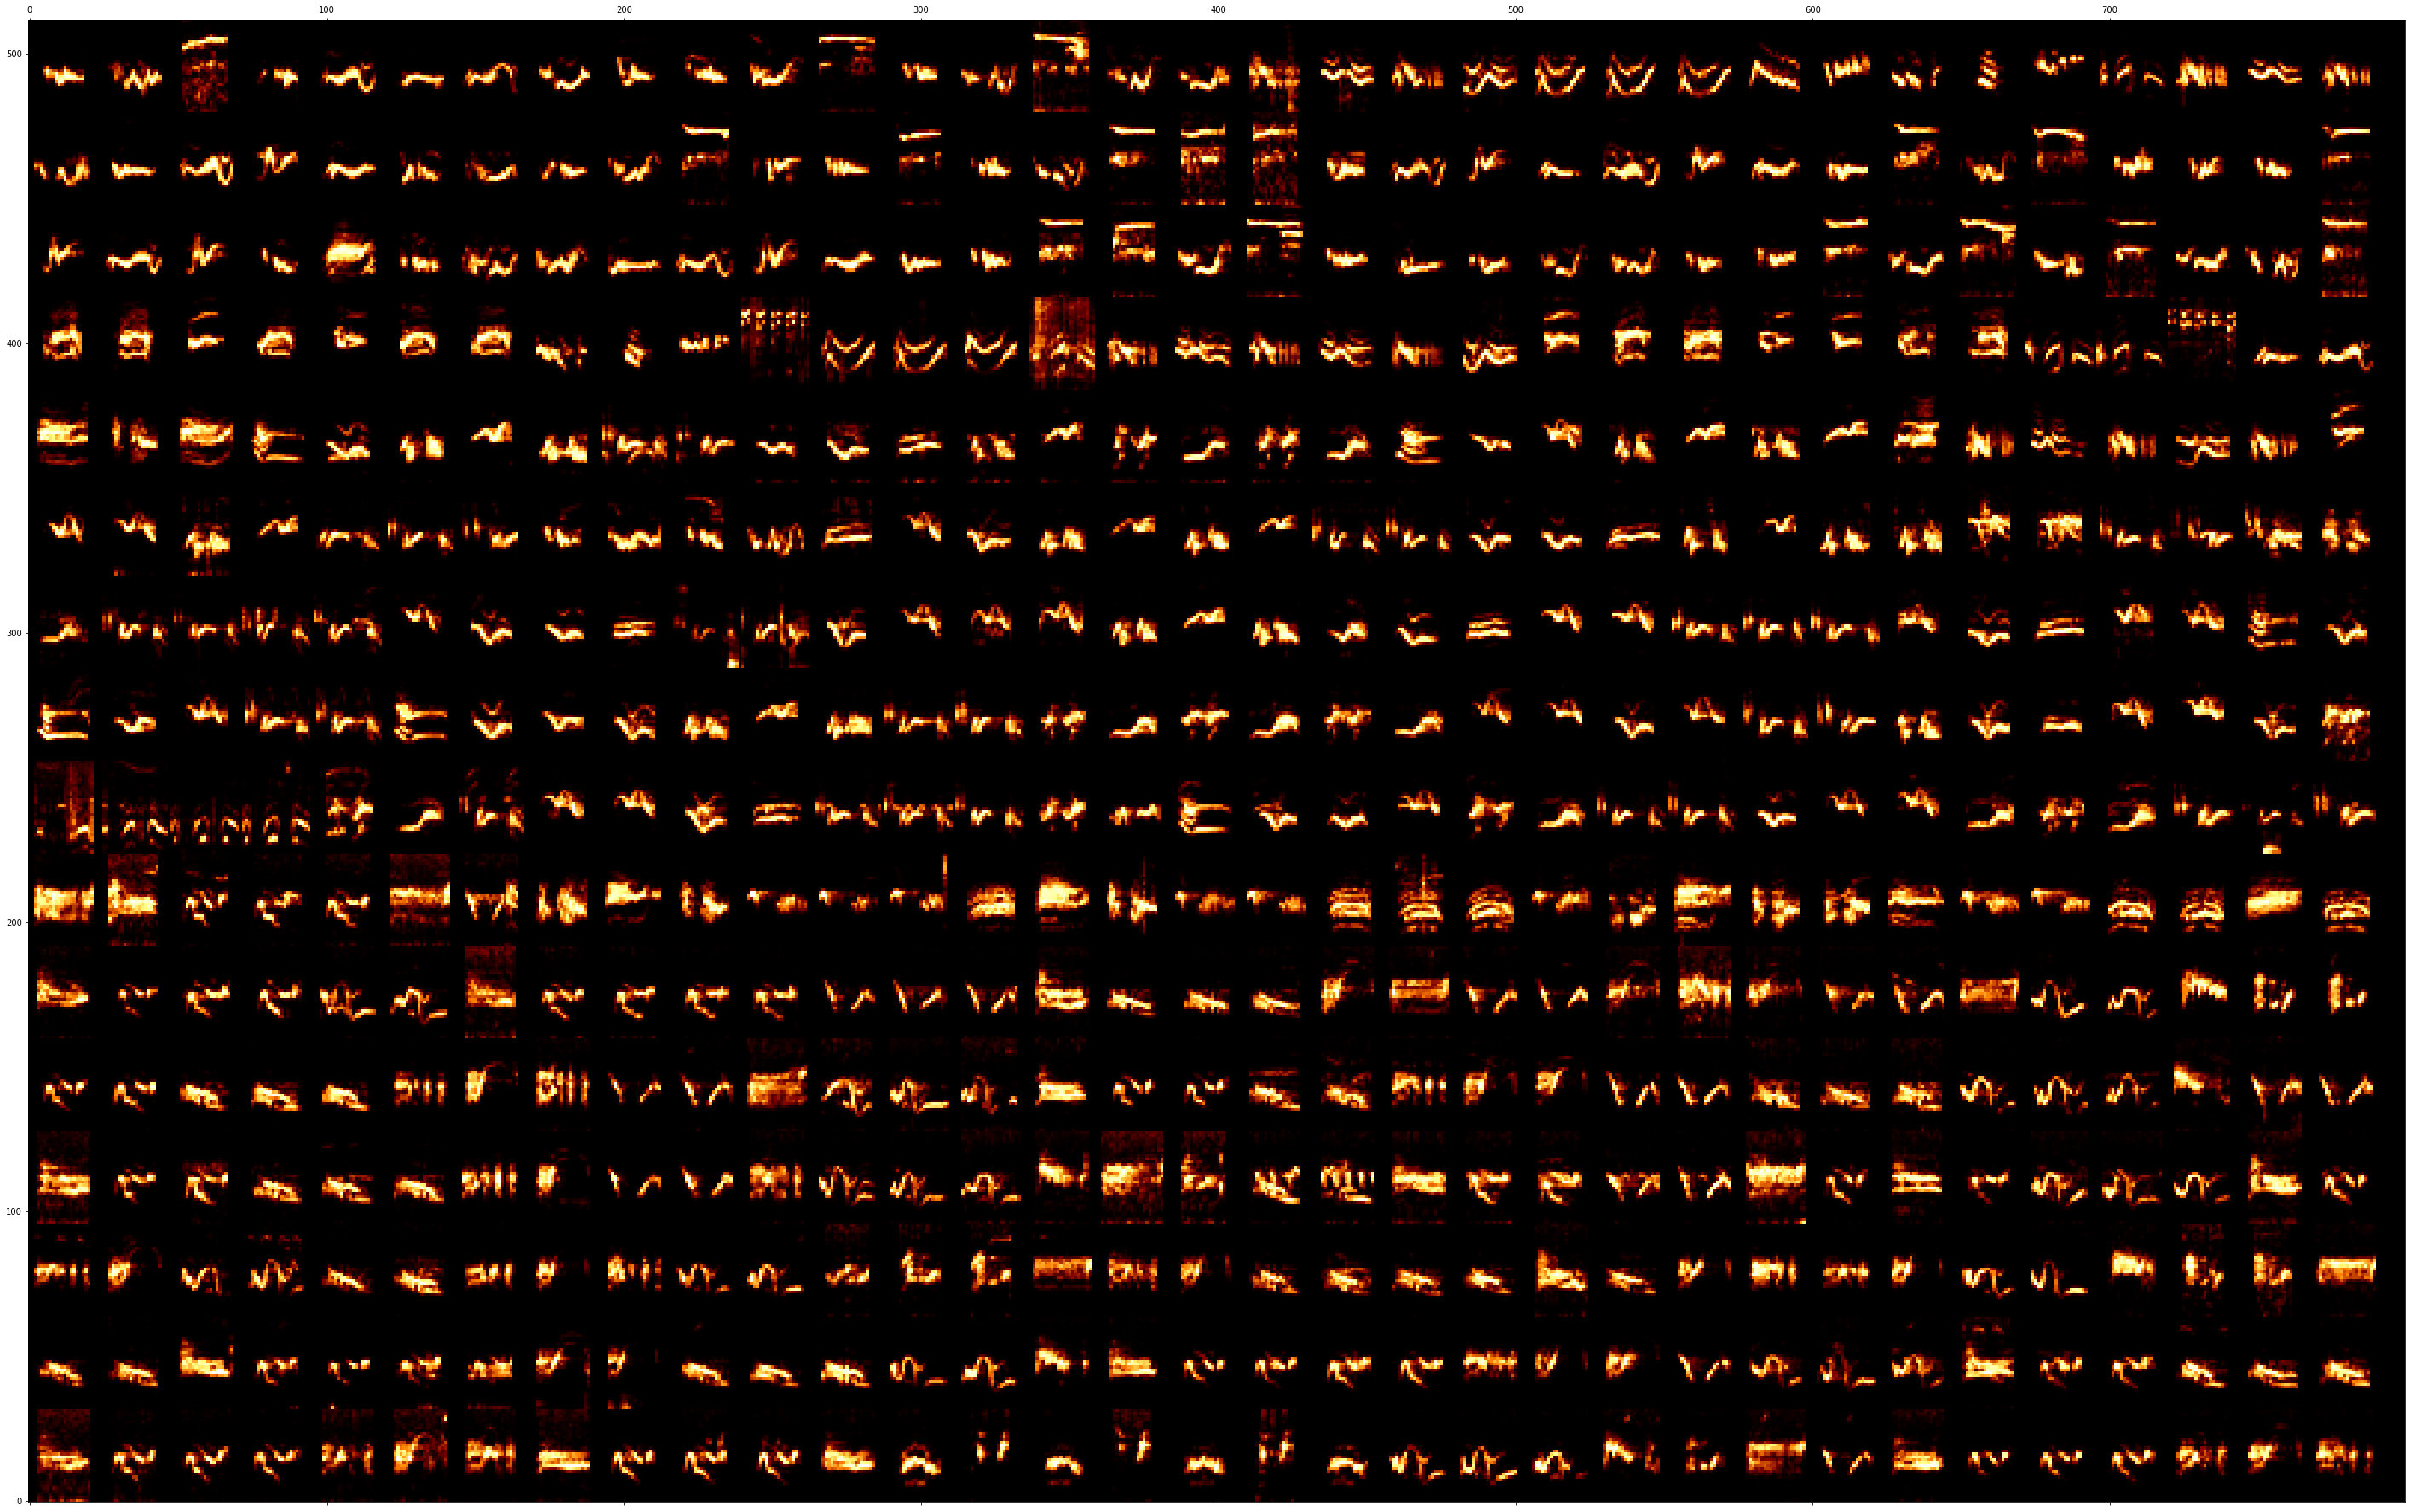

CATH-TLR11 261
(50.0, 16) (256, 800) 25.0 32 800


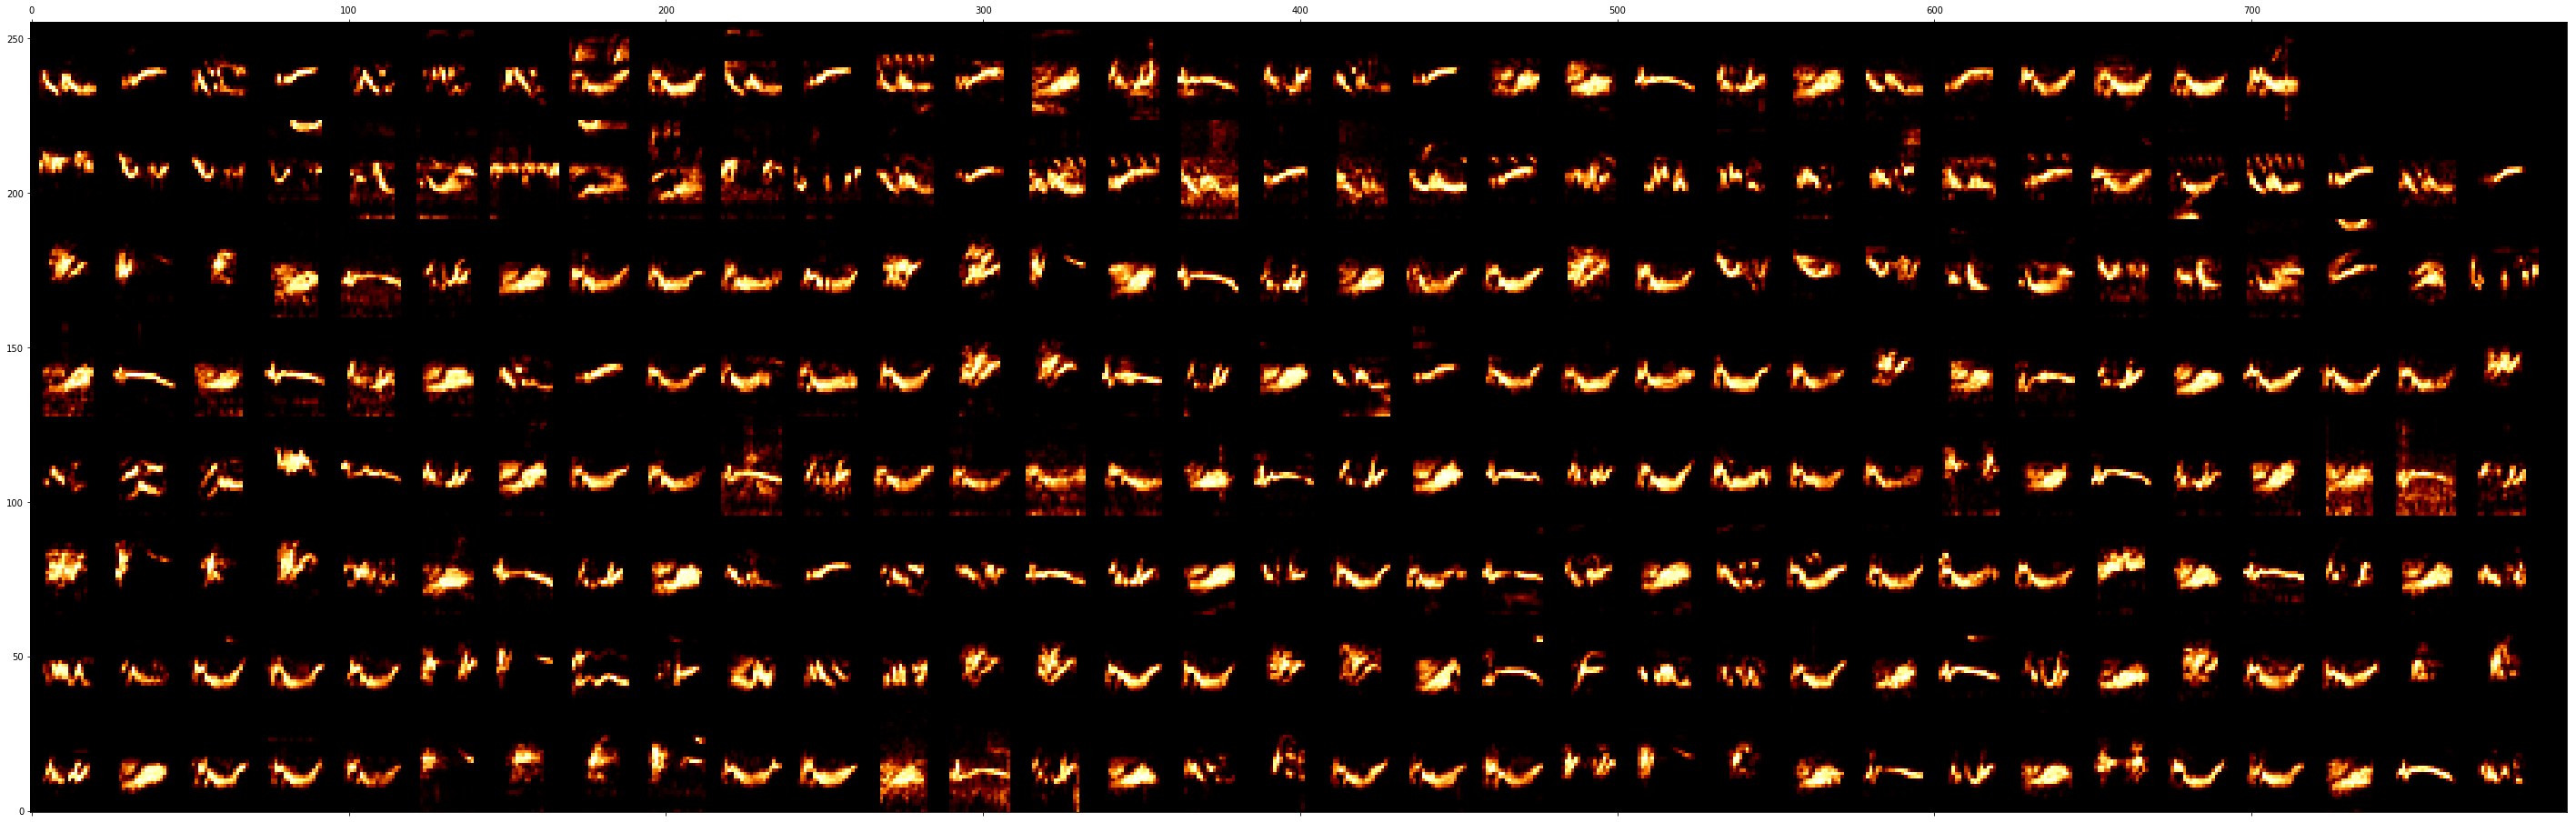

CATH-TLR12 670
(50.0, 32) (512, 800) 25.0 32 800


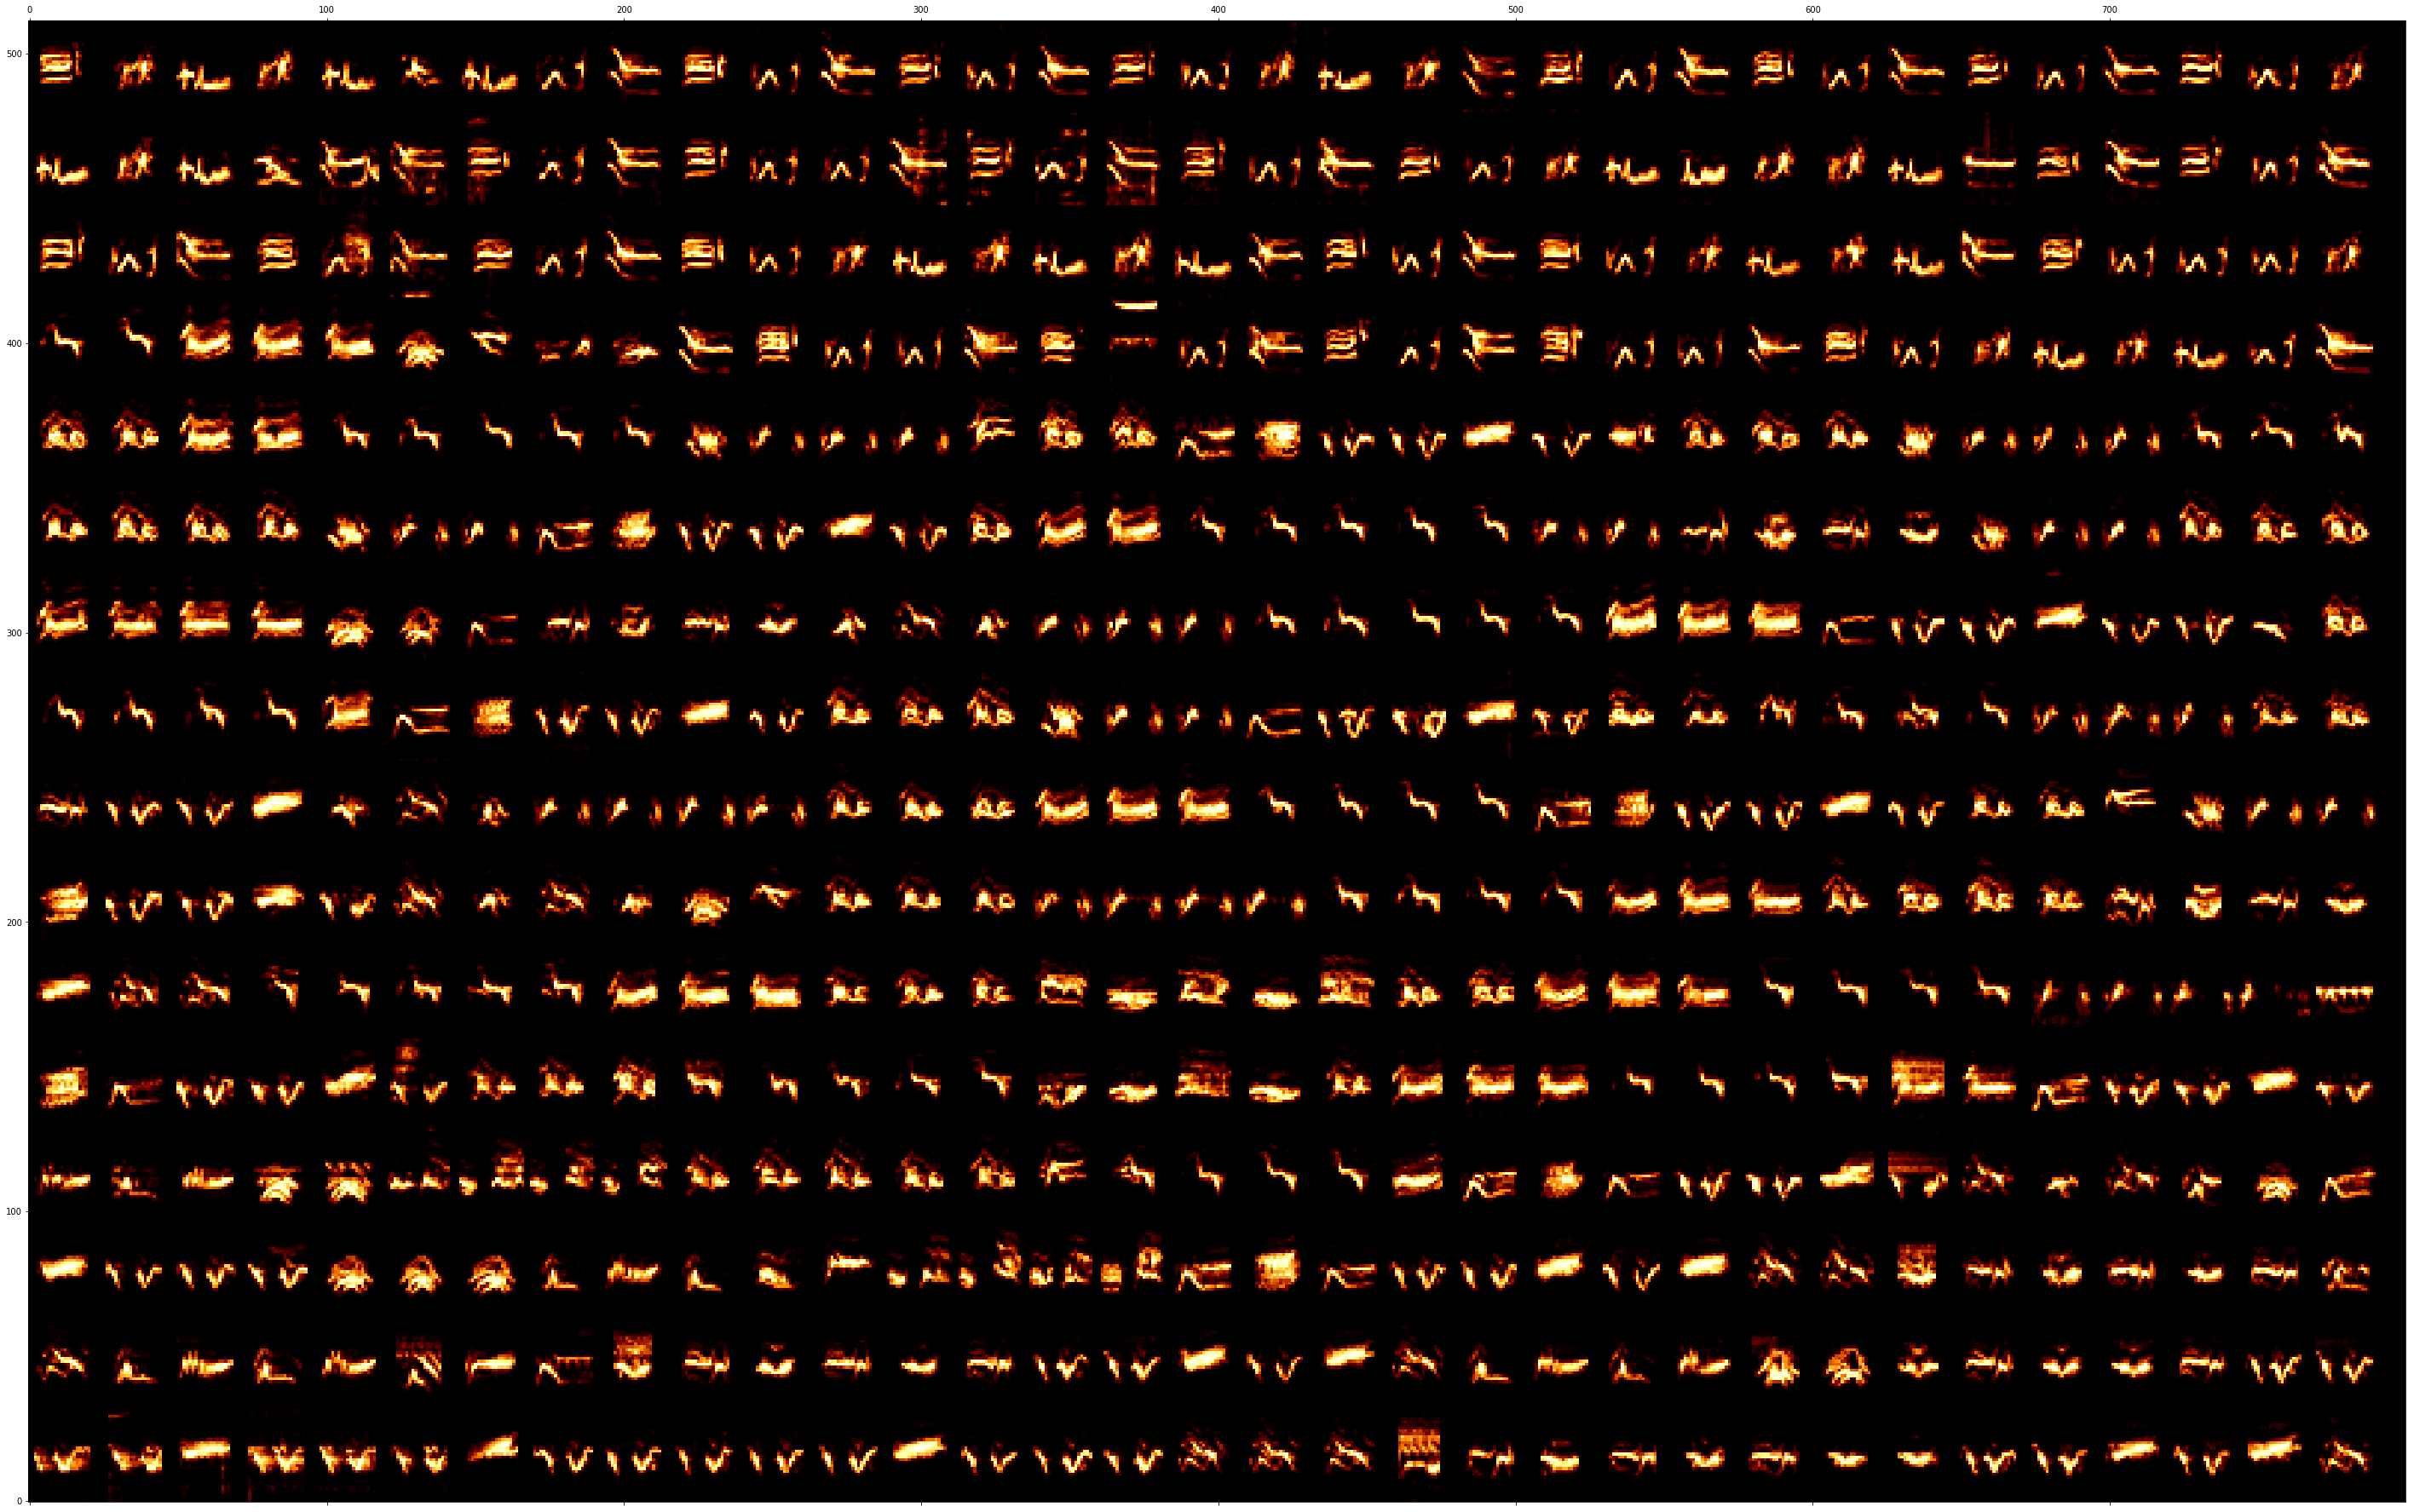

CATH-TLR13 34
(50.0, 4) (64, 800) 25.0 32 800


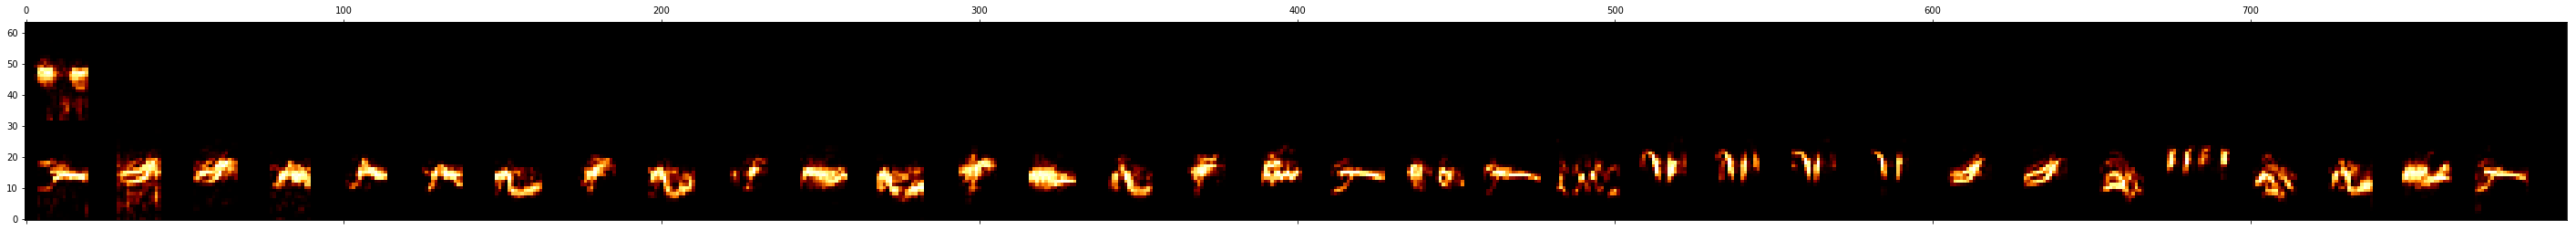

CATH-TLR14 324
(50.0, 20) (320, 800) 25.0 32 800


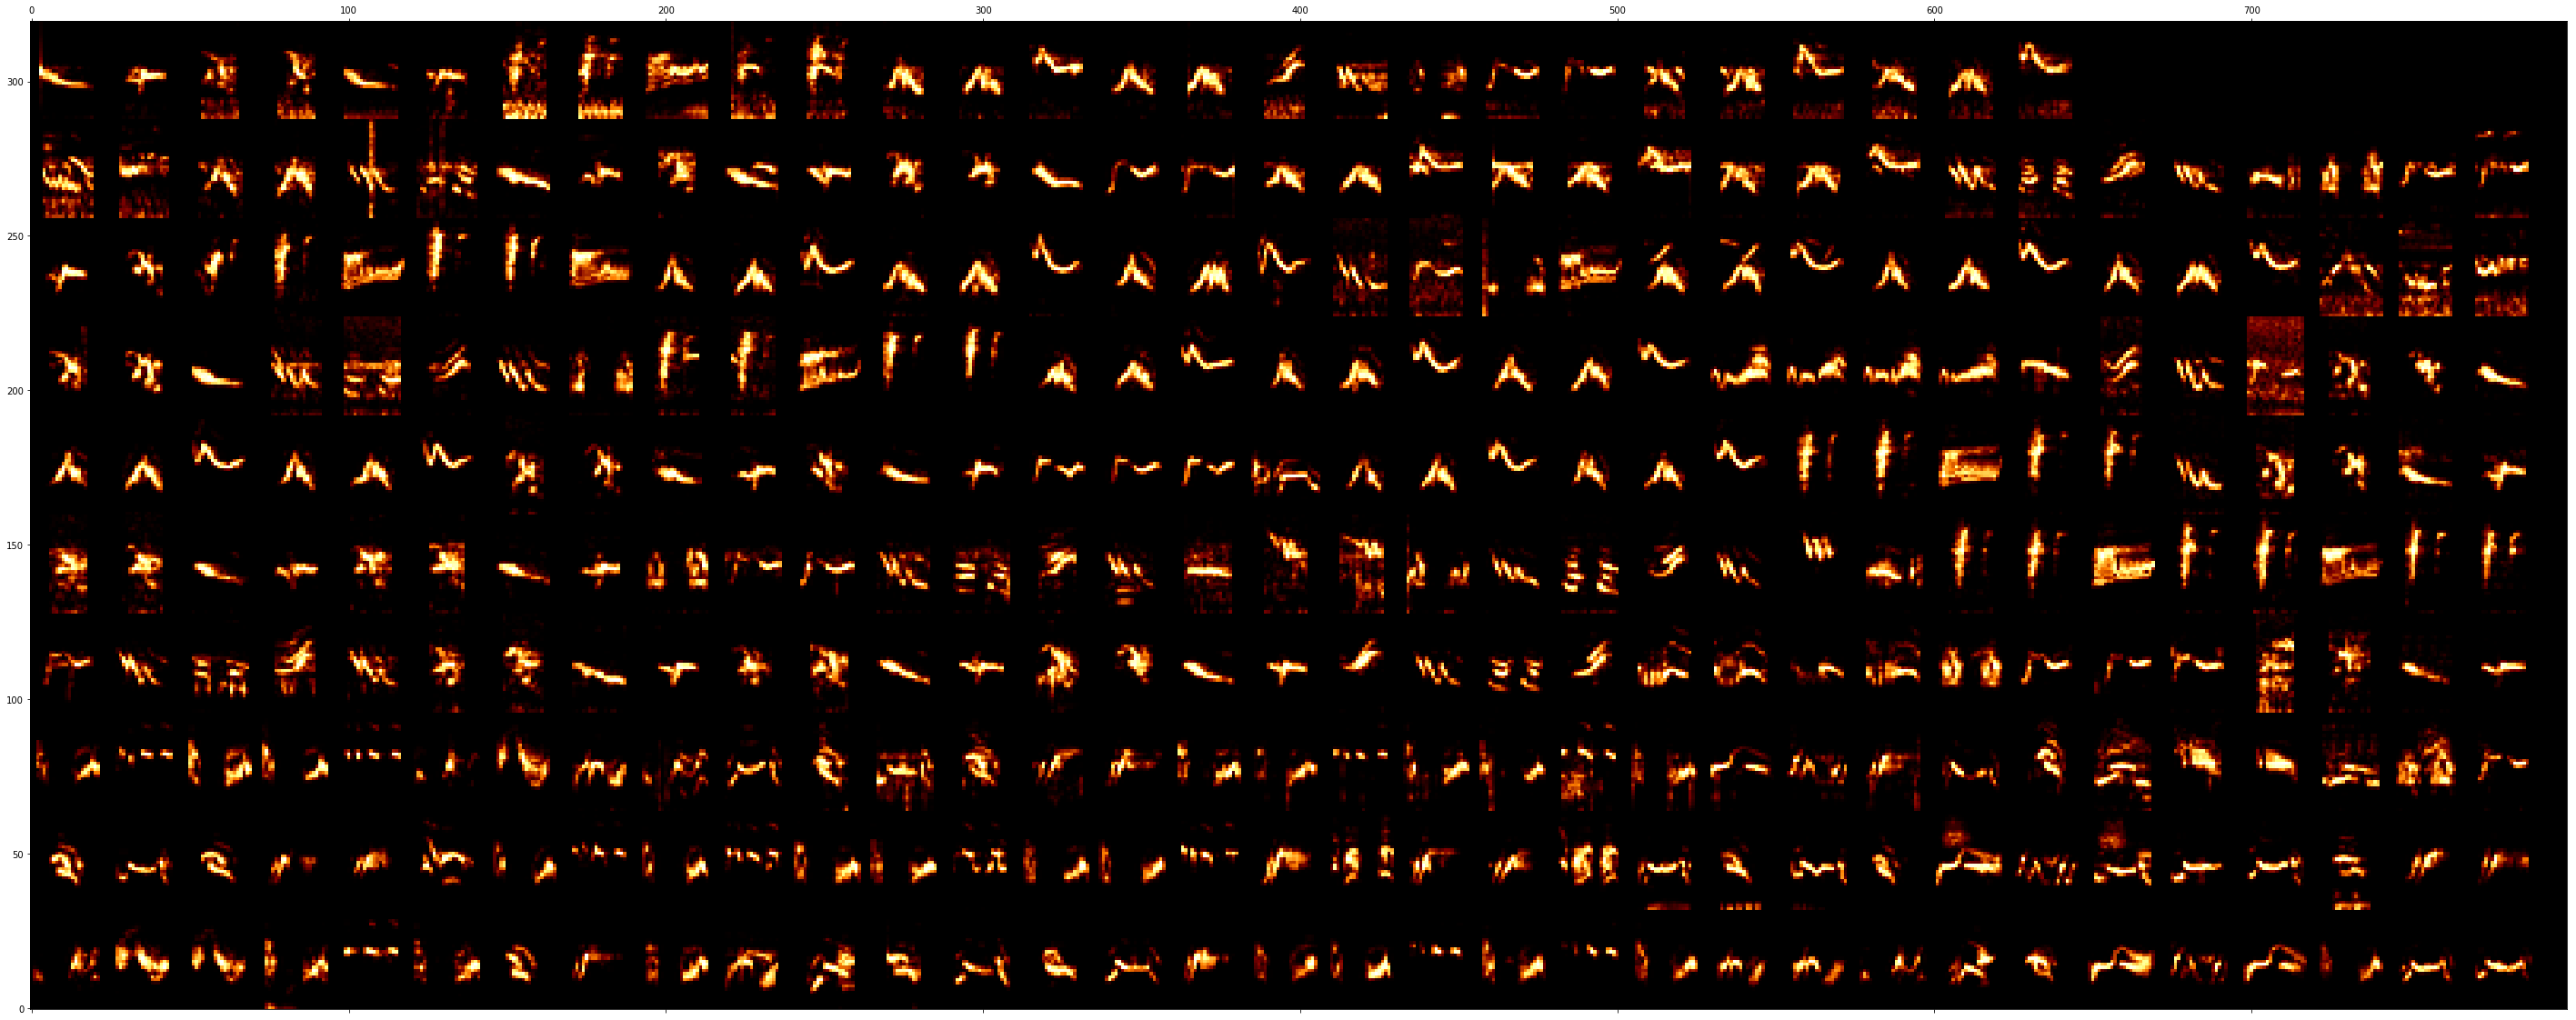

CATH-TLR2 1340
(50.0, 32) (512, 800) 25.0 32 800


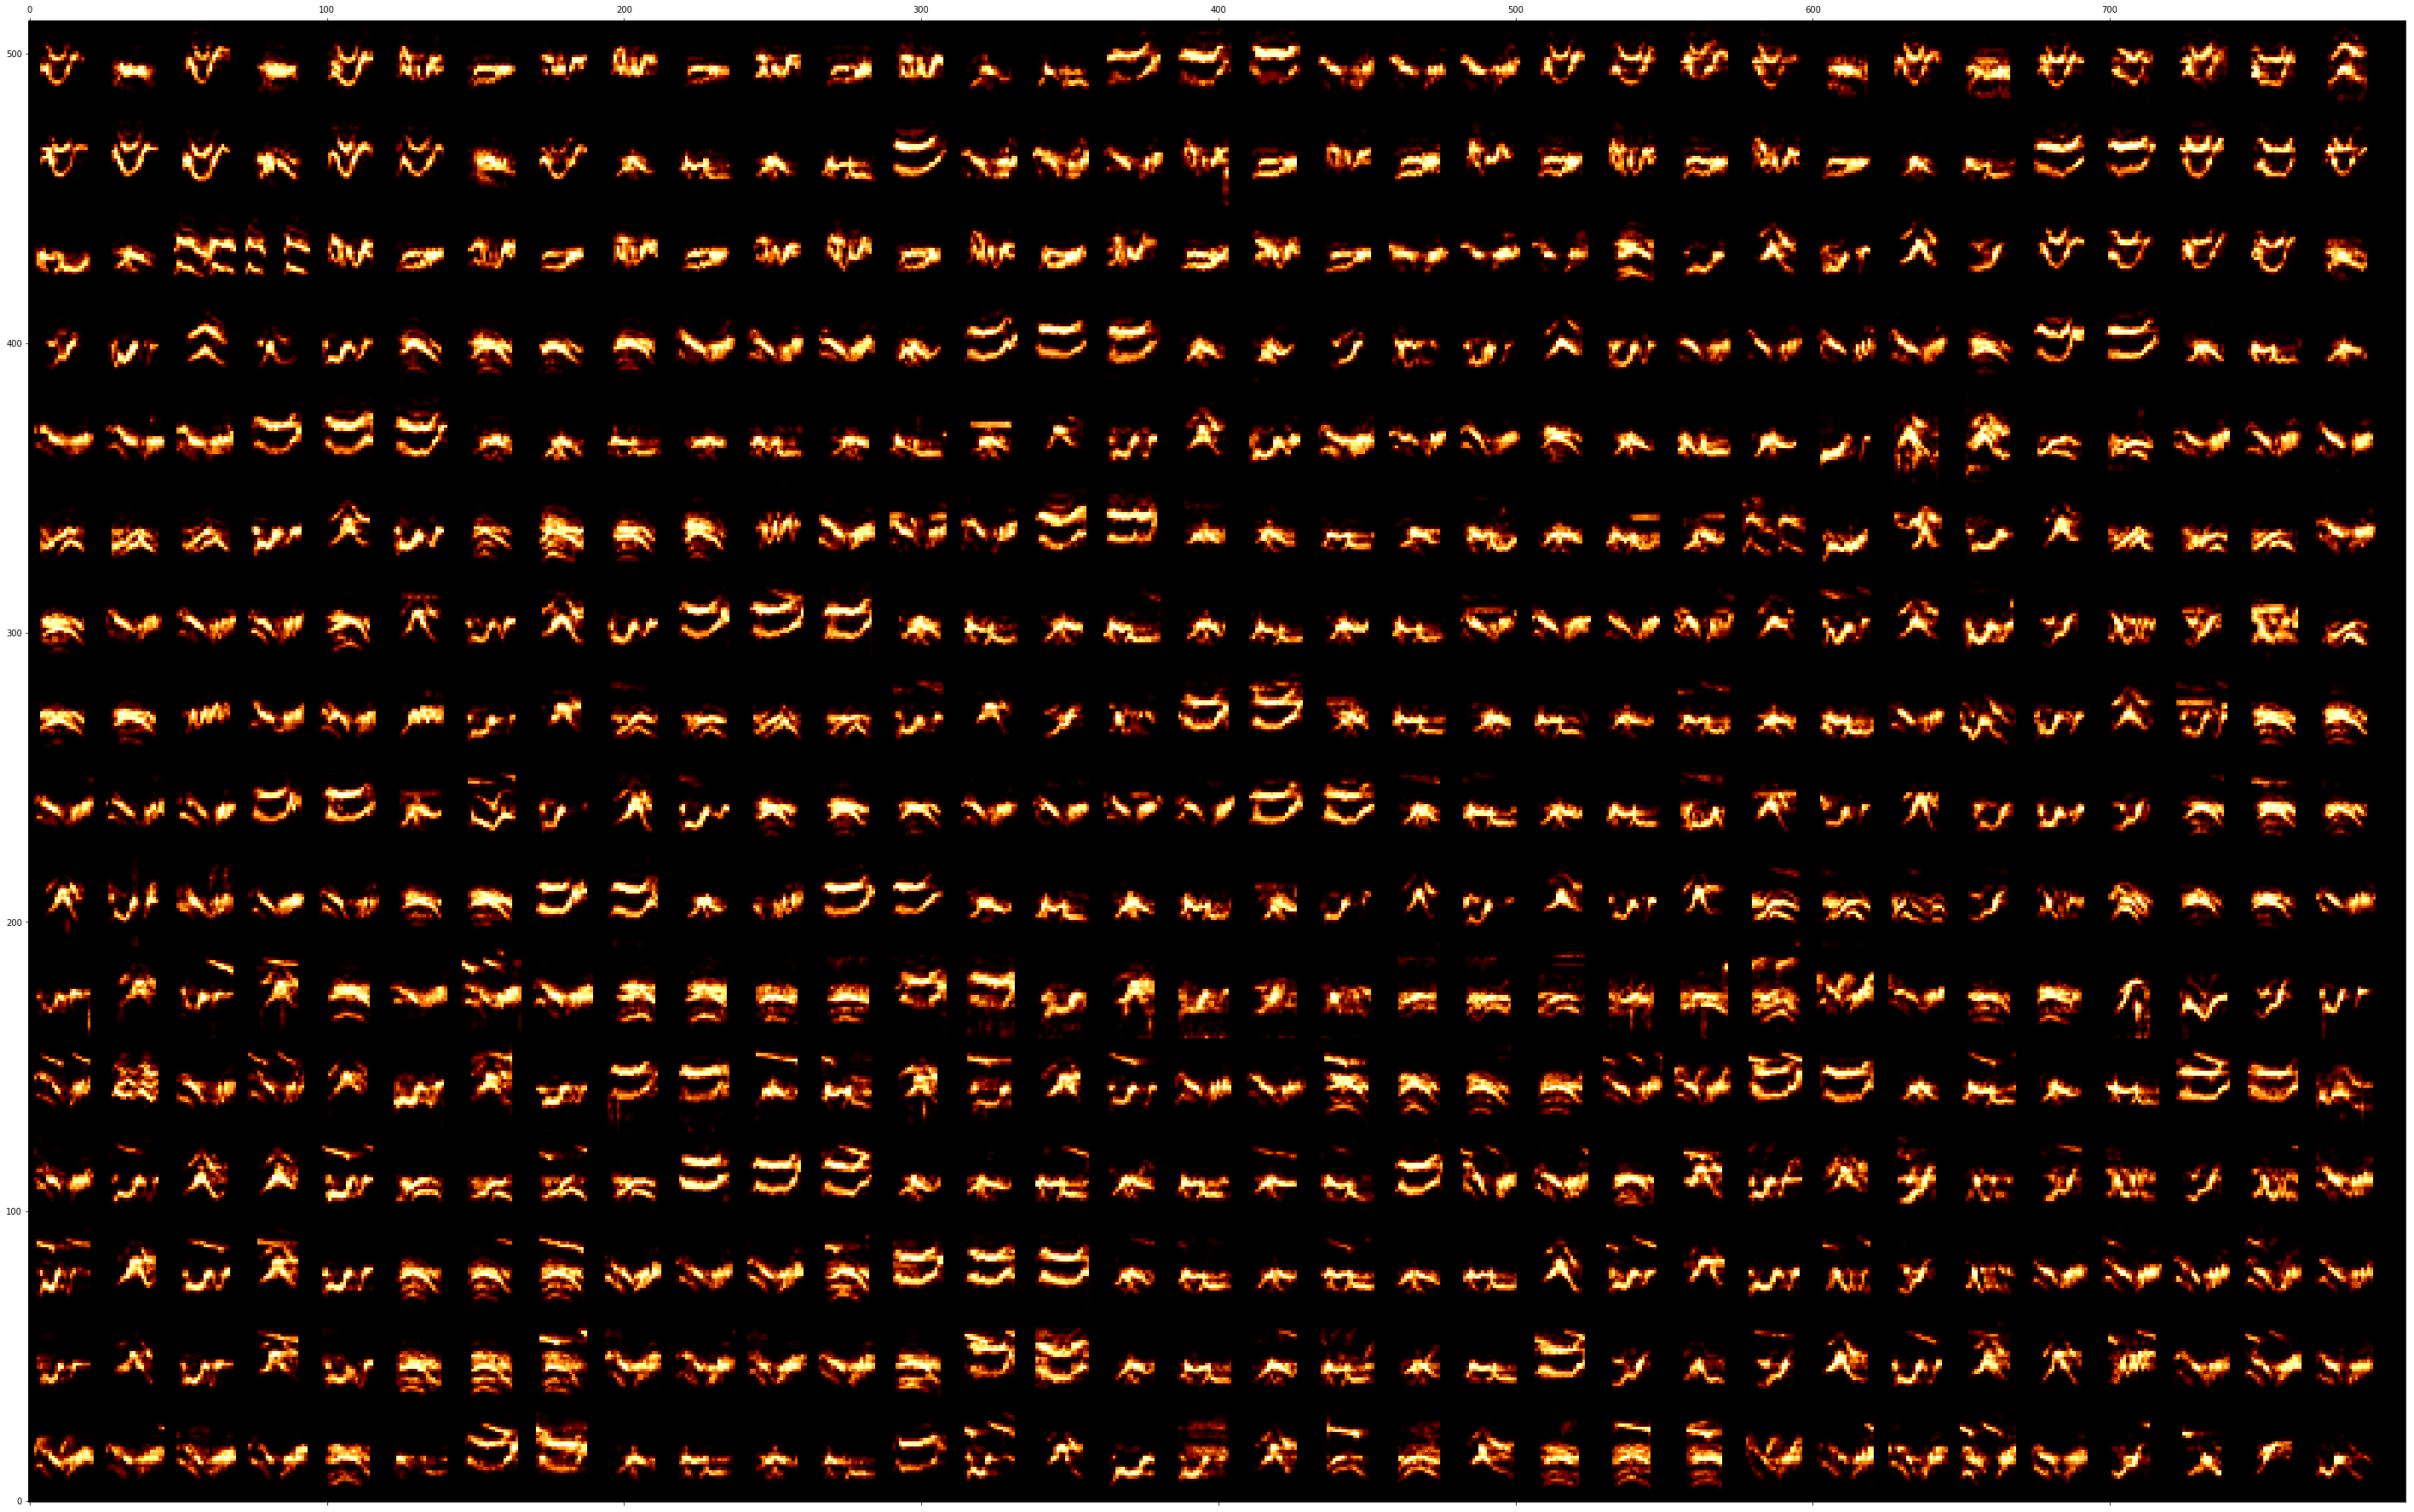

CATH-TLR3 621
(50.0, 32) (512, 800) 25.0 32 800


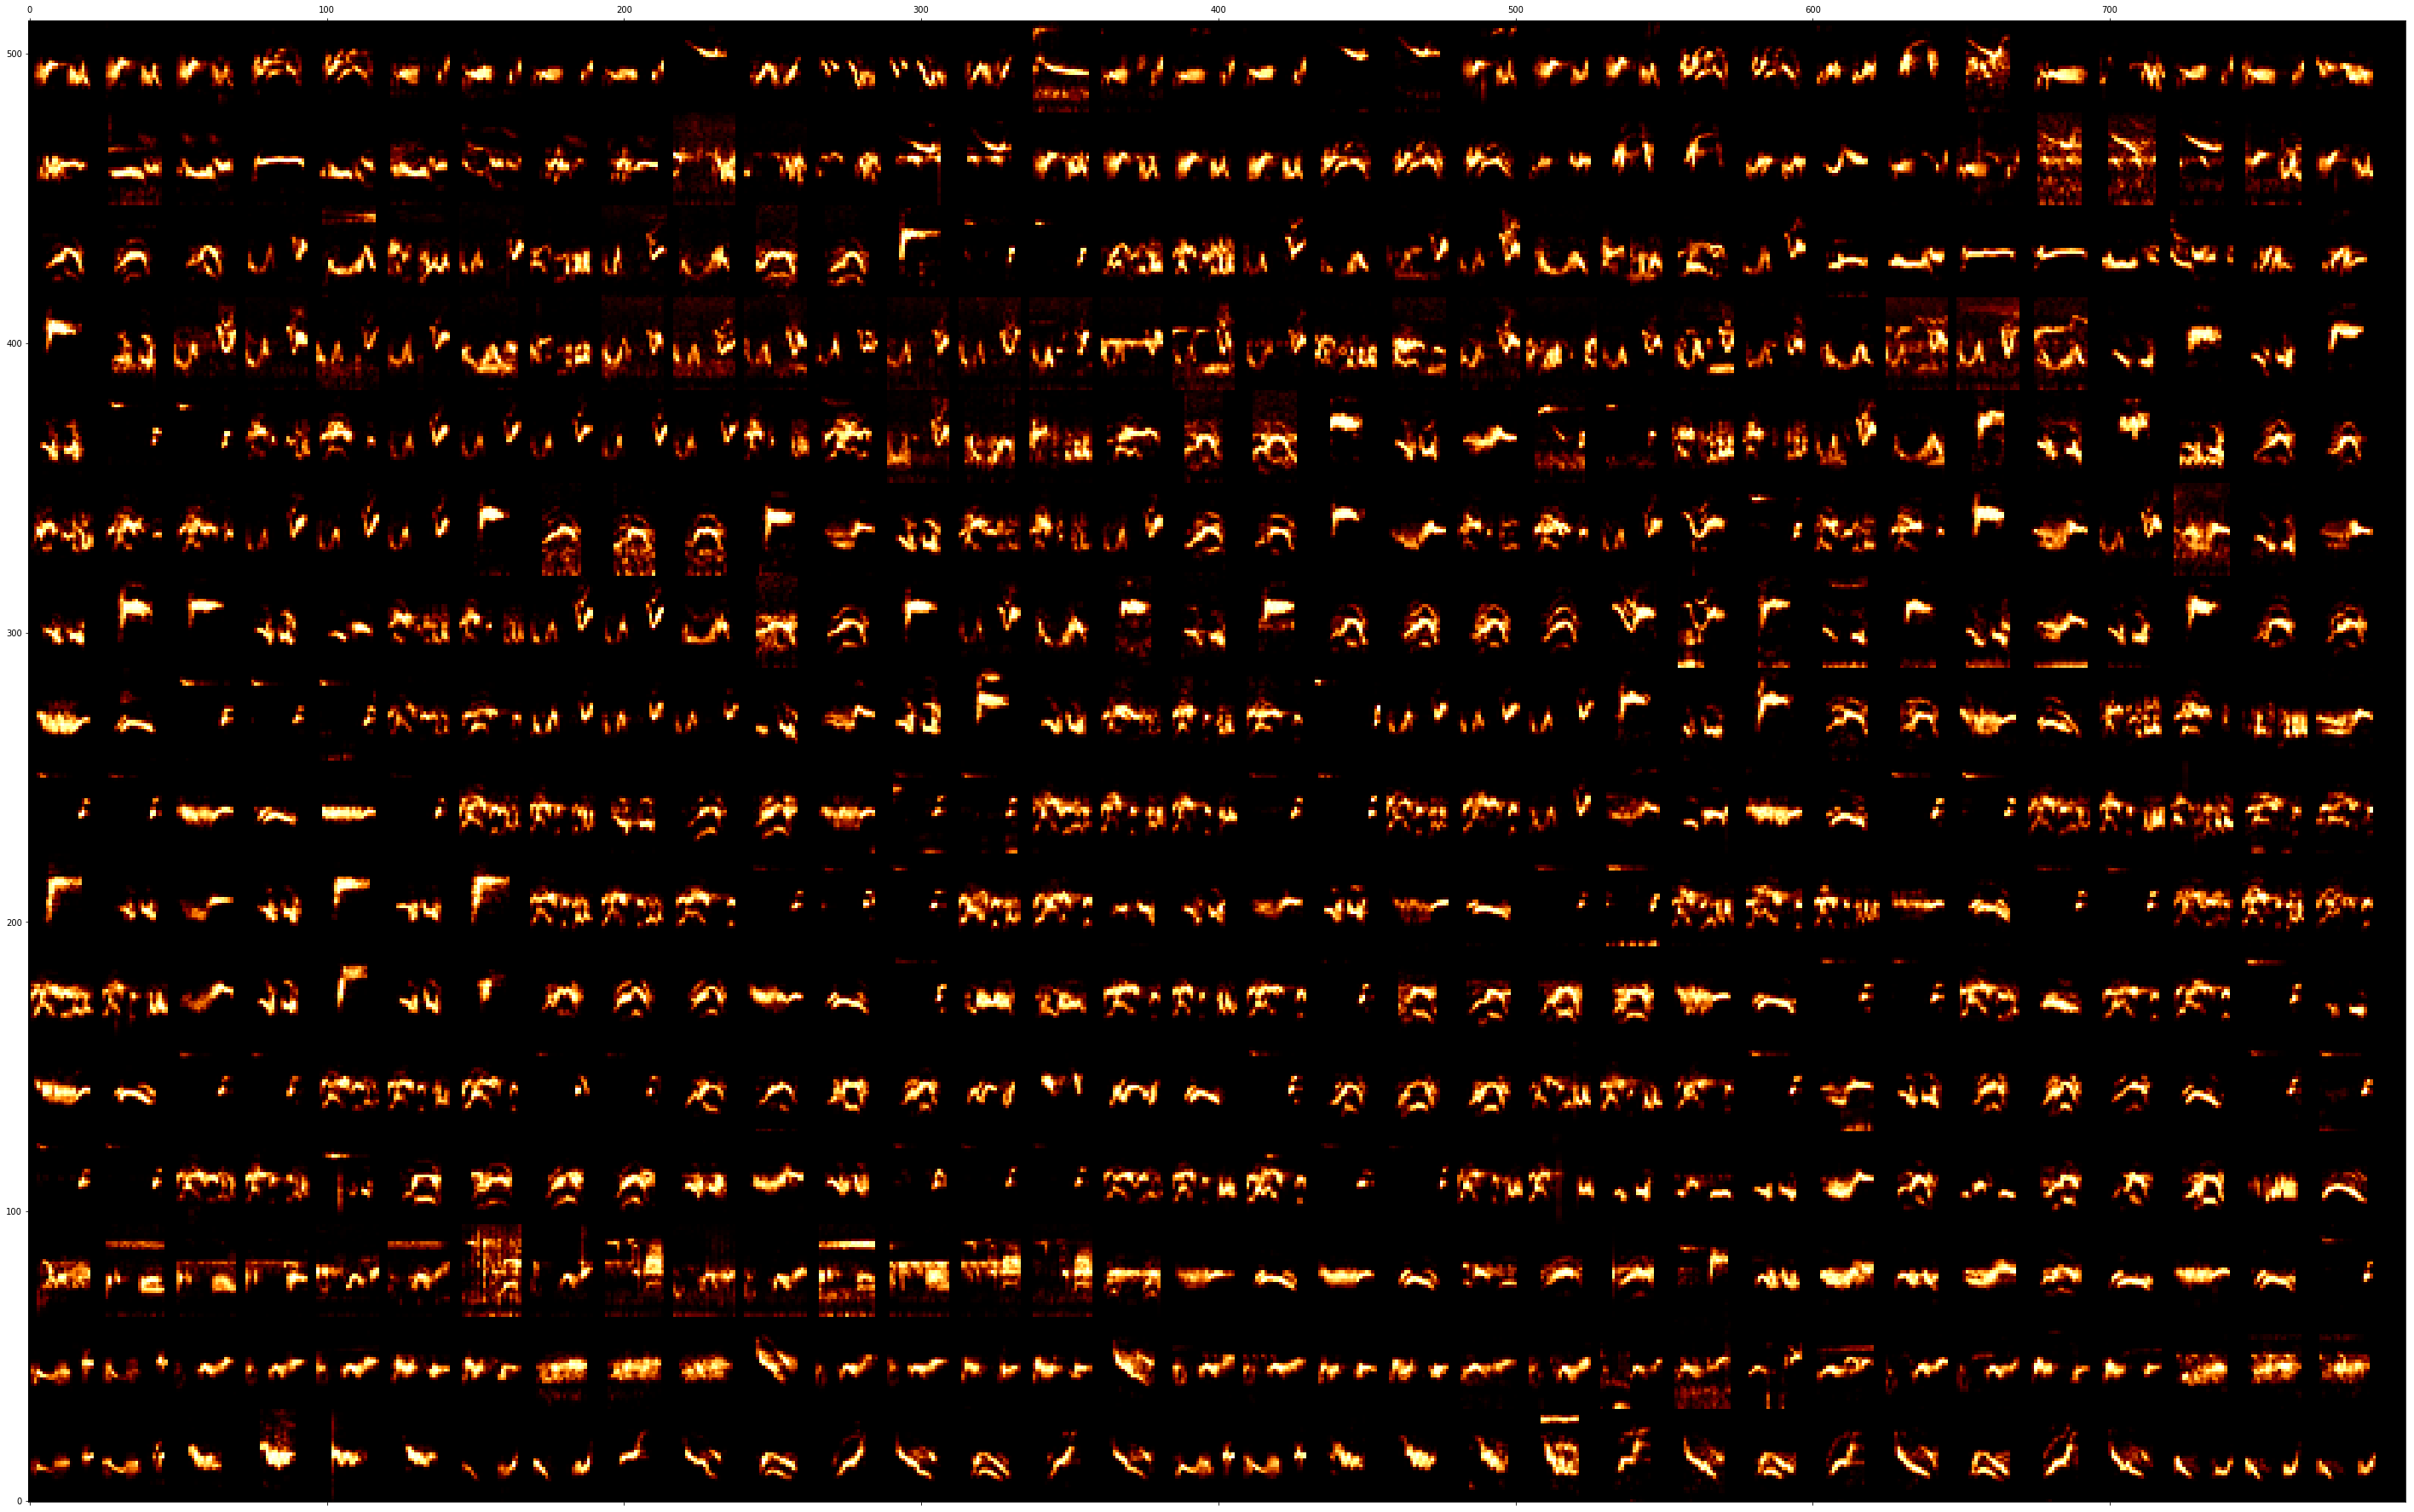

CATH-TLR4 664
(50.0, 32) (512, 800) 25.0 32 800


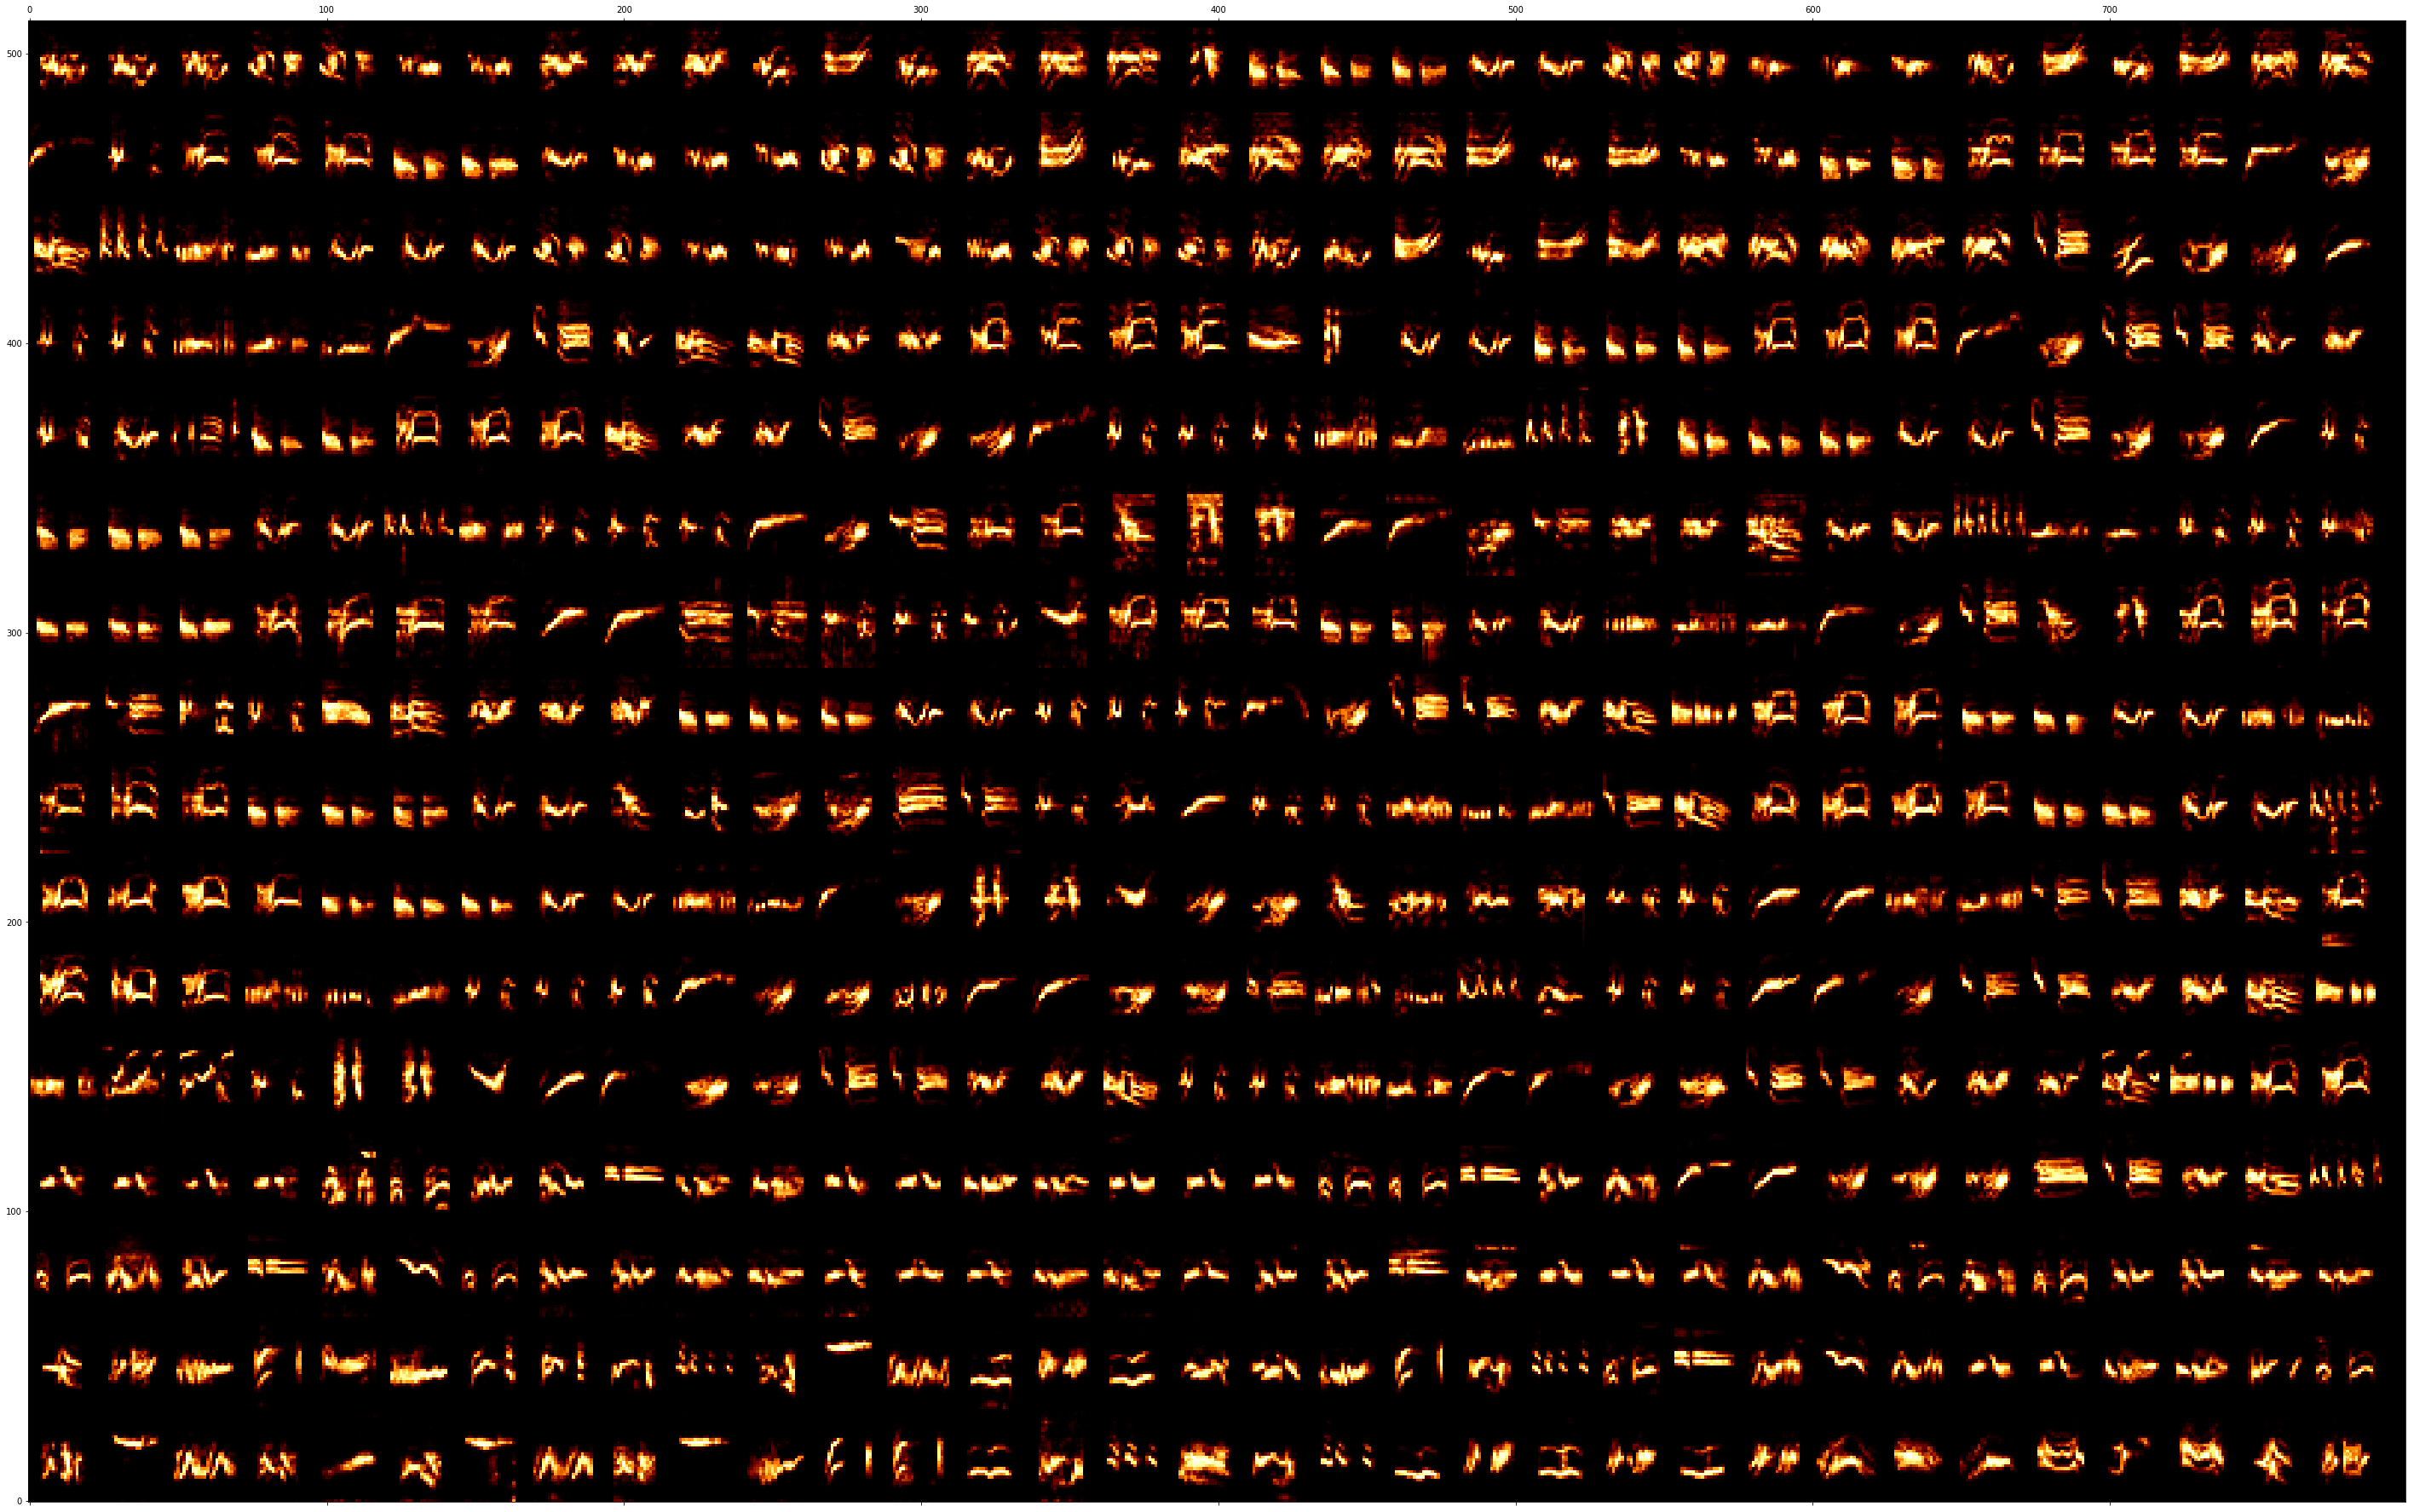

CATH-TLR5 305
(50.0, 20) (320, 800) 25.0 32 800


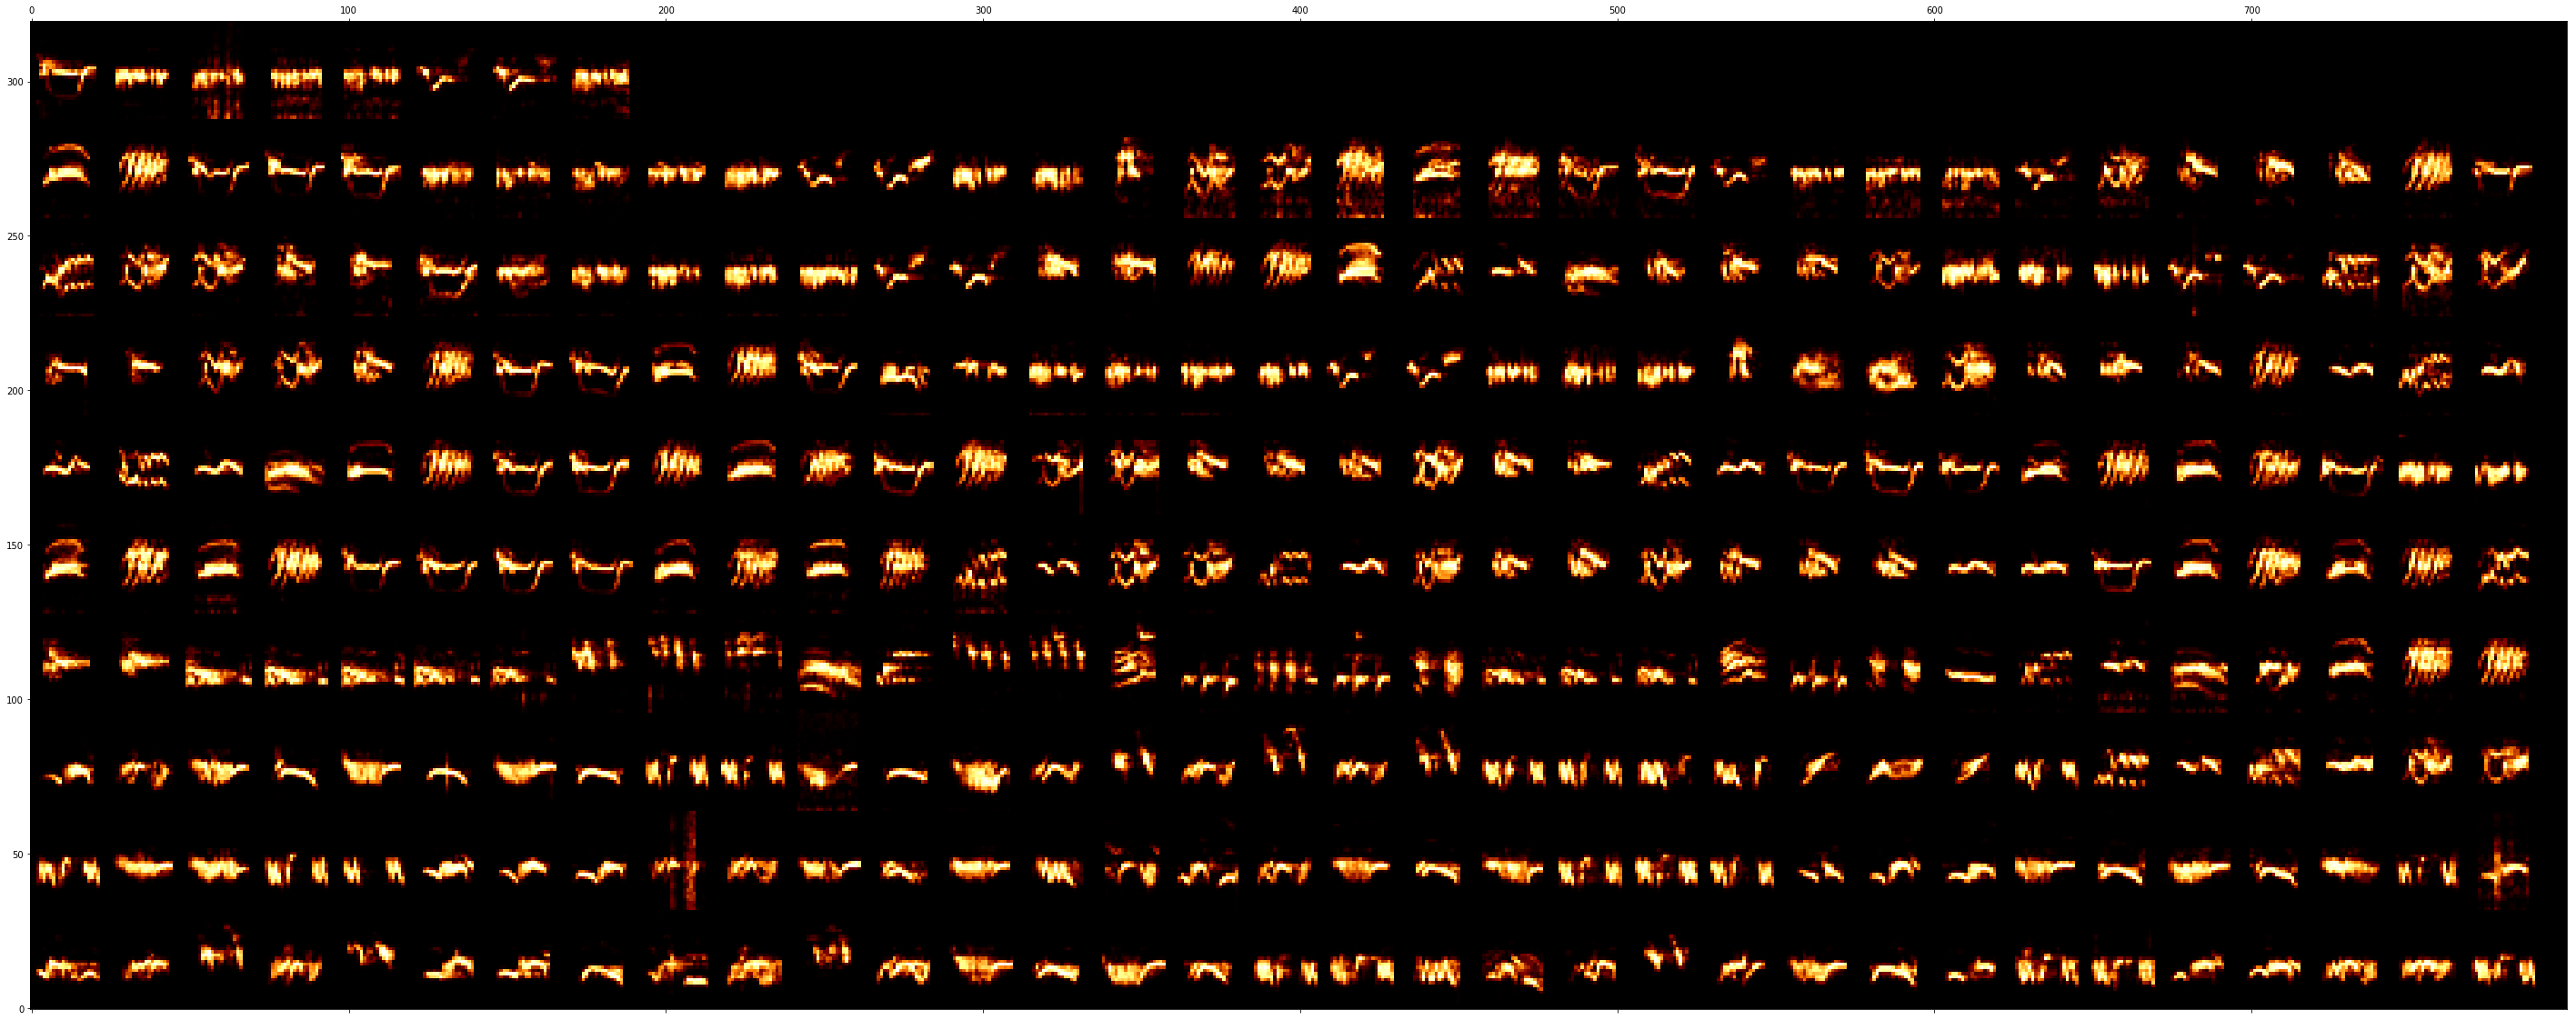

CATH-TLR5 in 2013 295
(50.0, 18) (288, 800) 25.0 32 800


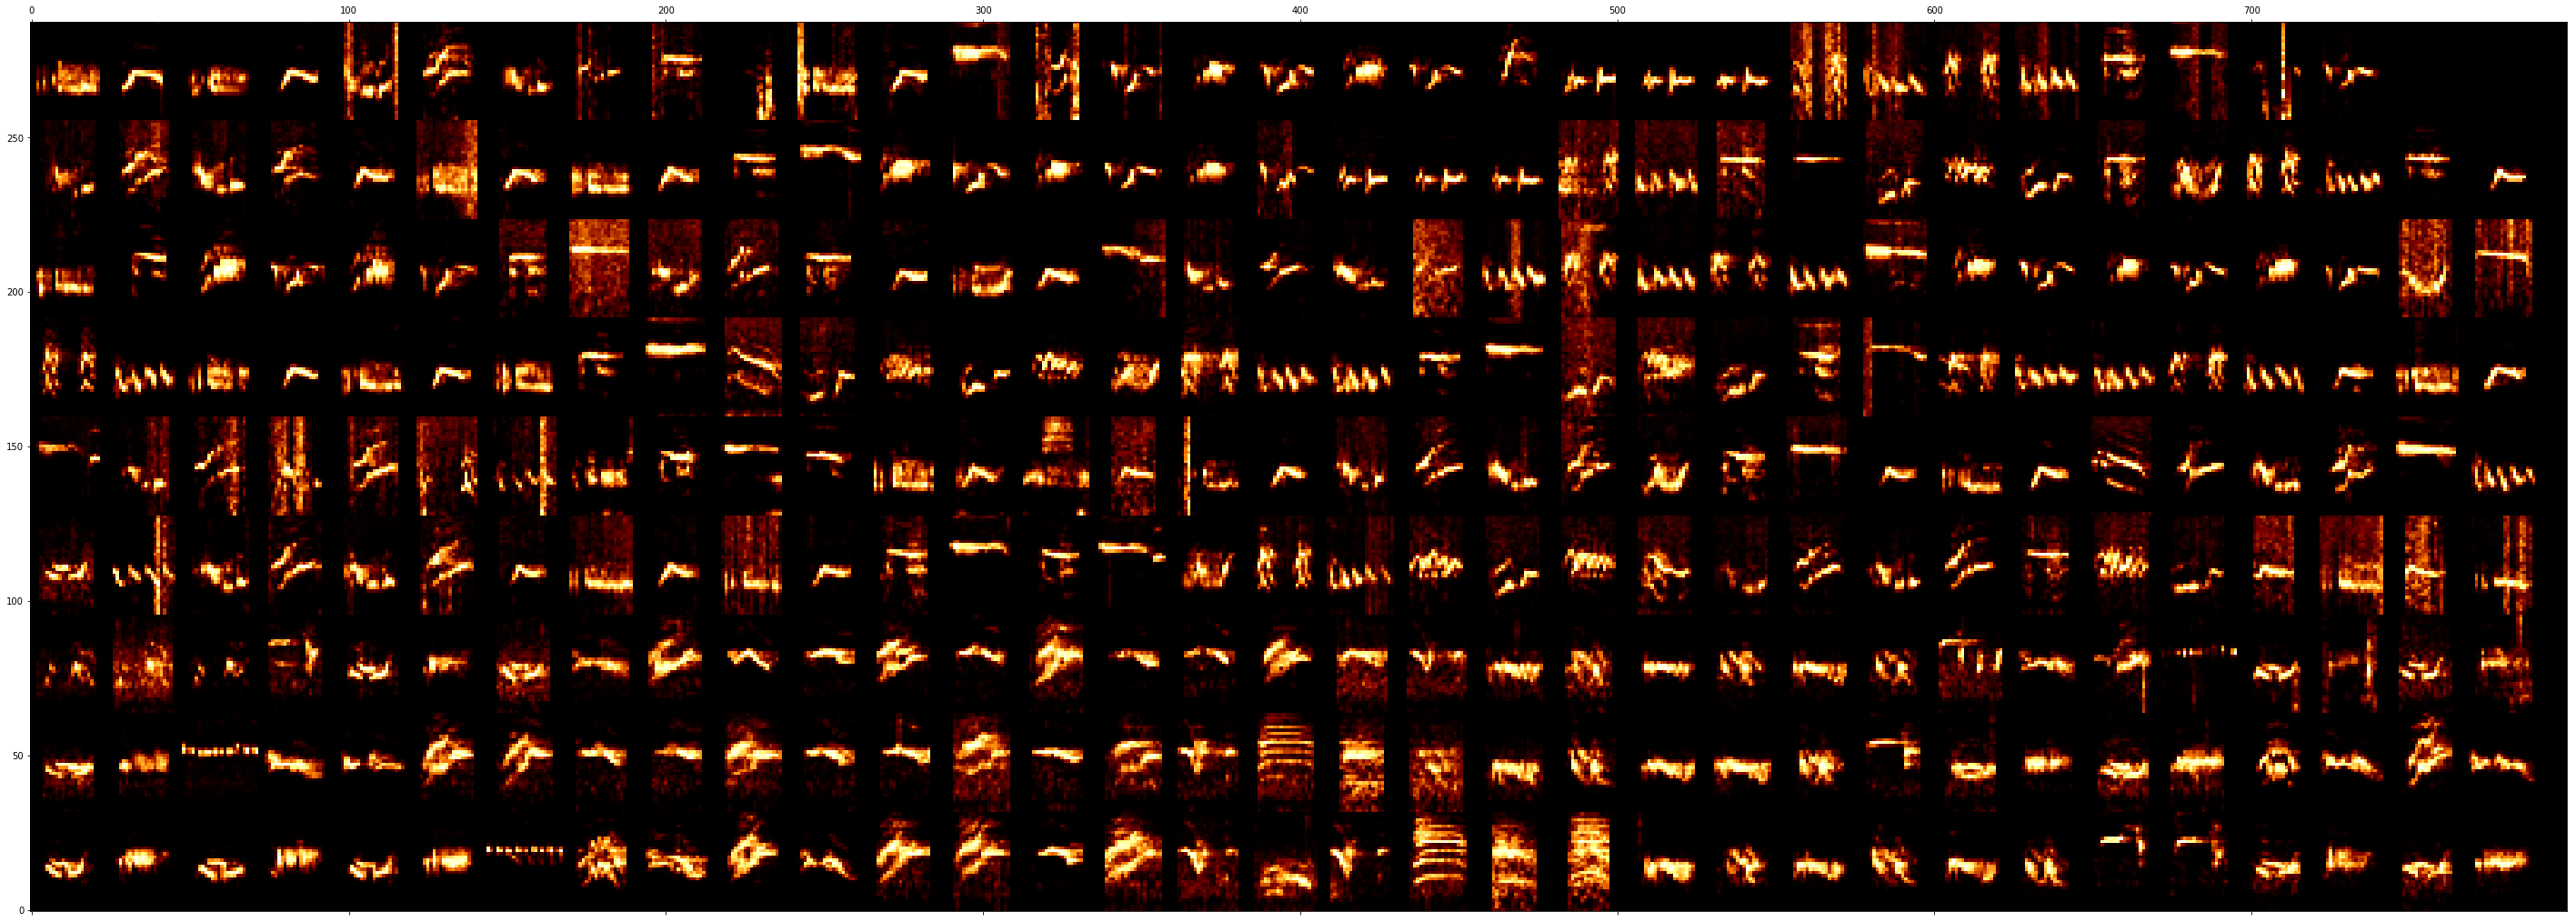

CATH-TLR6 587
(50.0, 32) (512, 800) 25.0 32 800


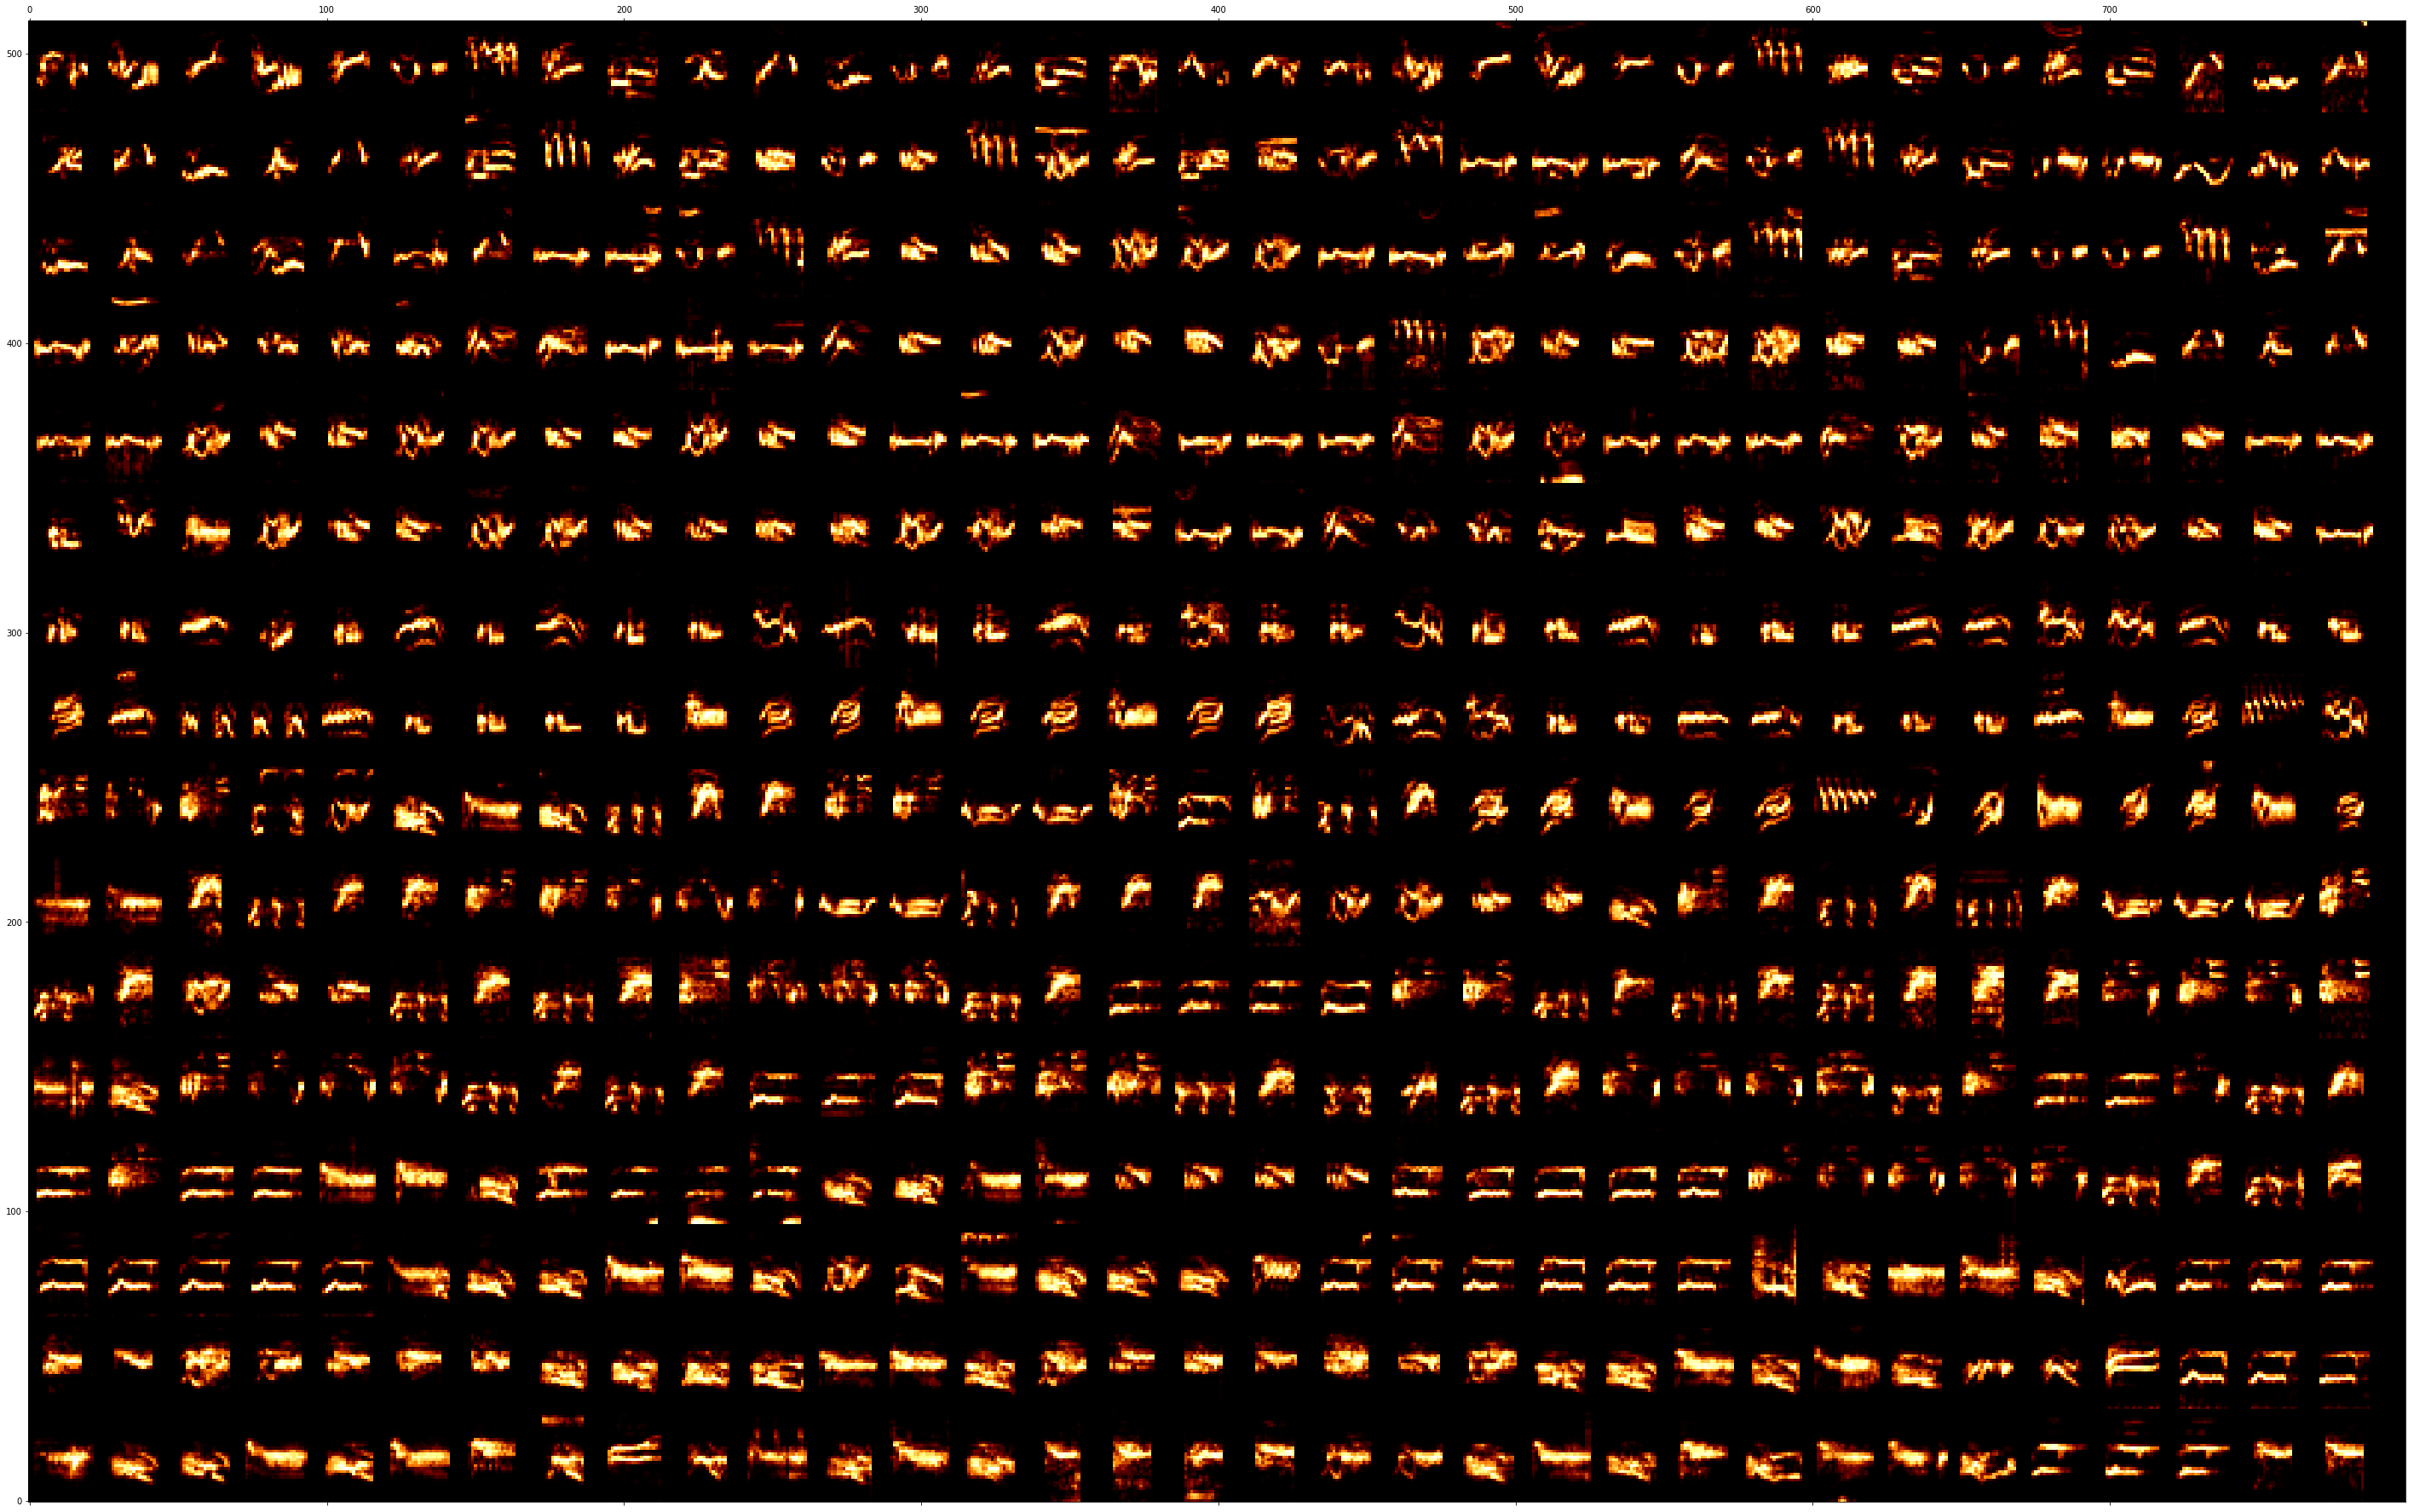

CATH-TLR7 1092
(50.0, 32) (512, 800) 25.0 32 800


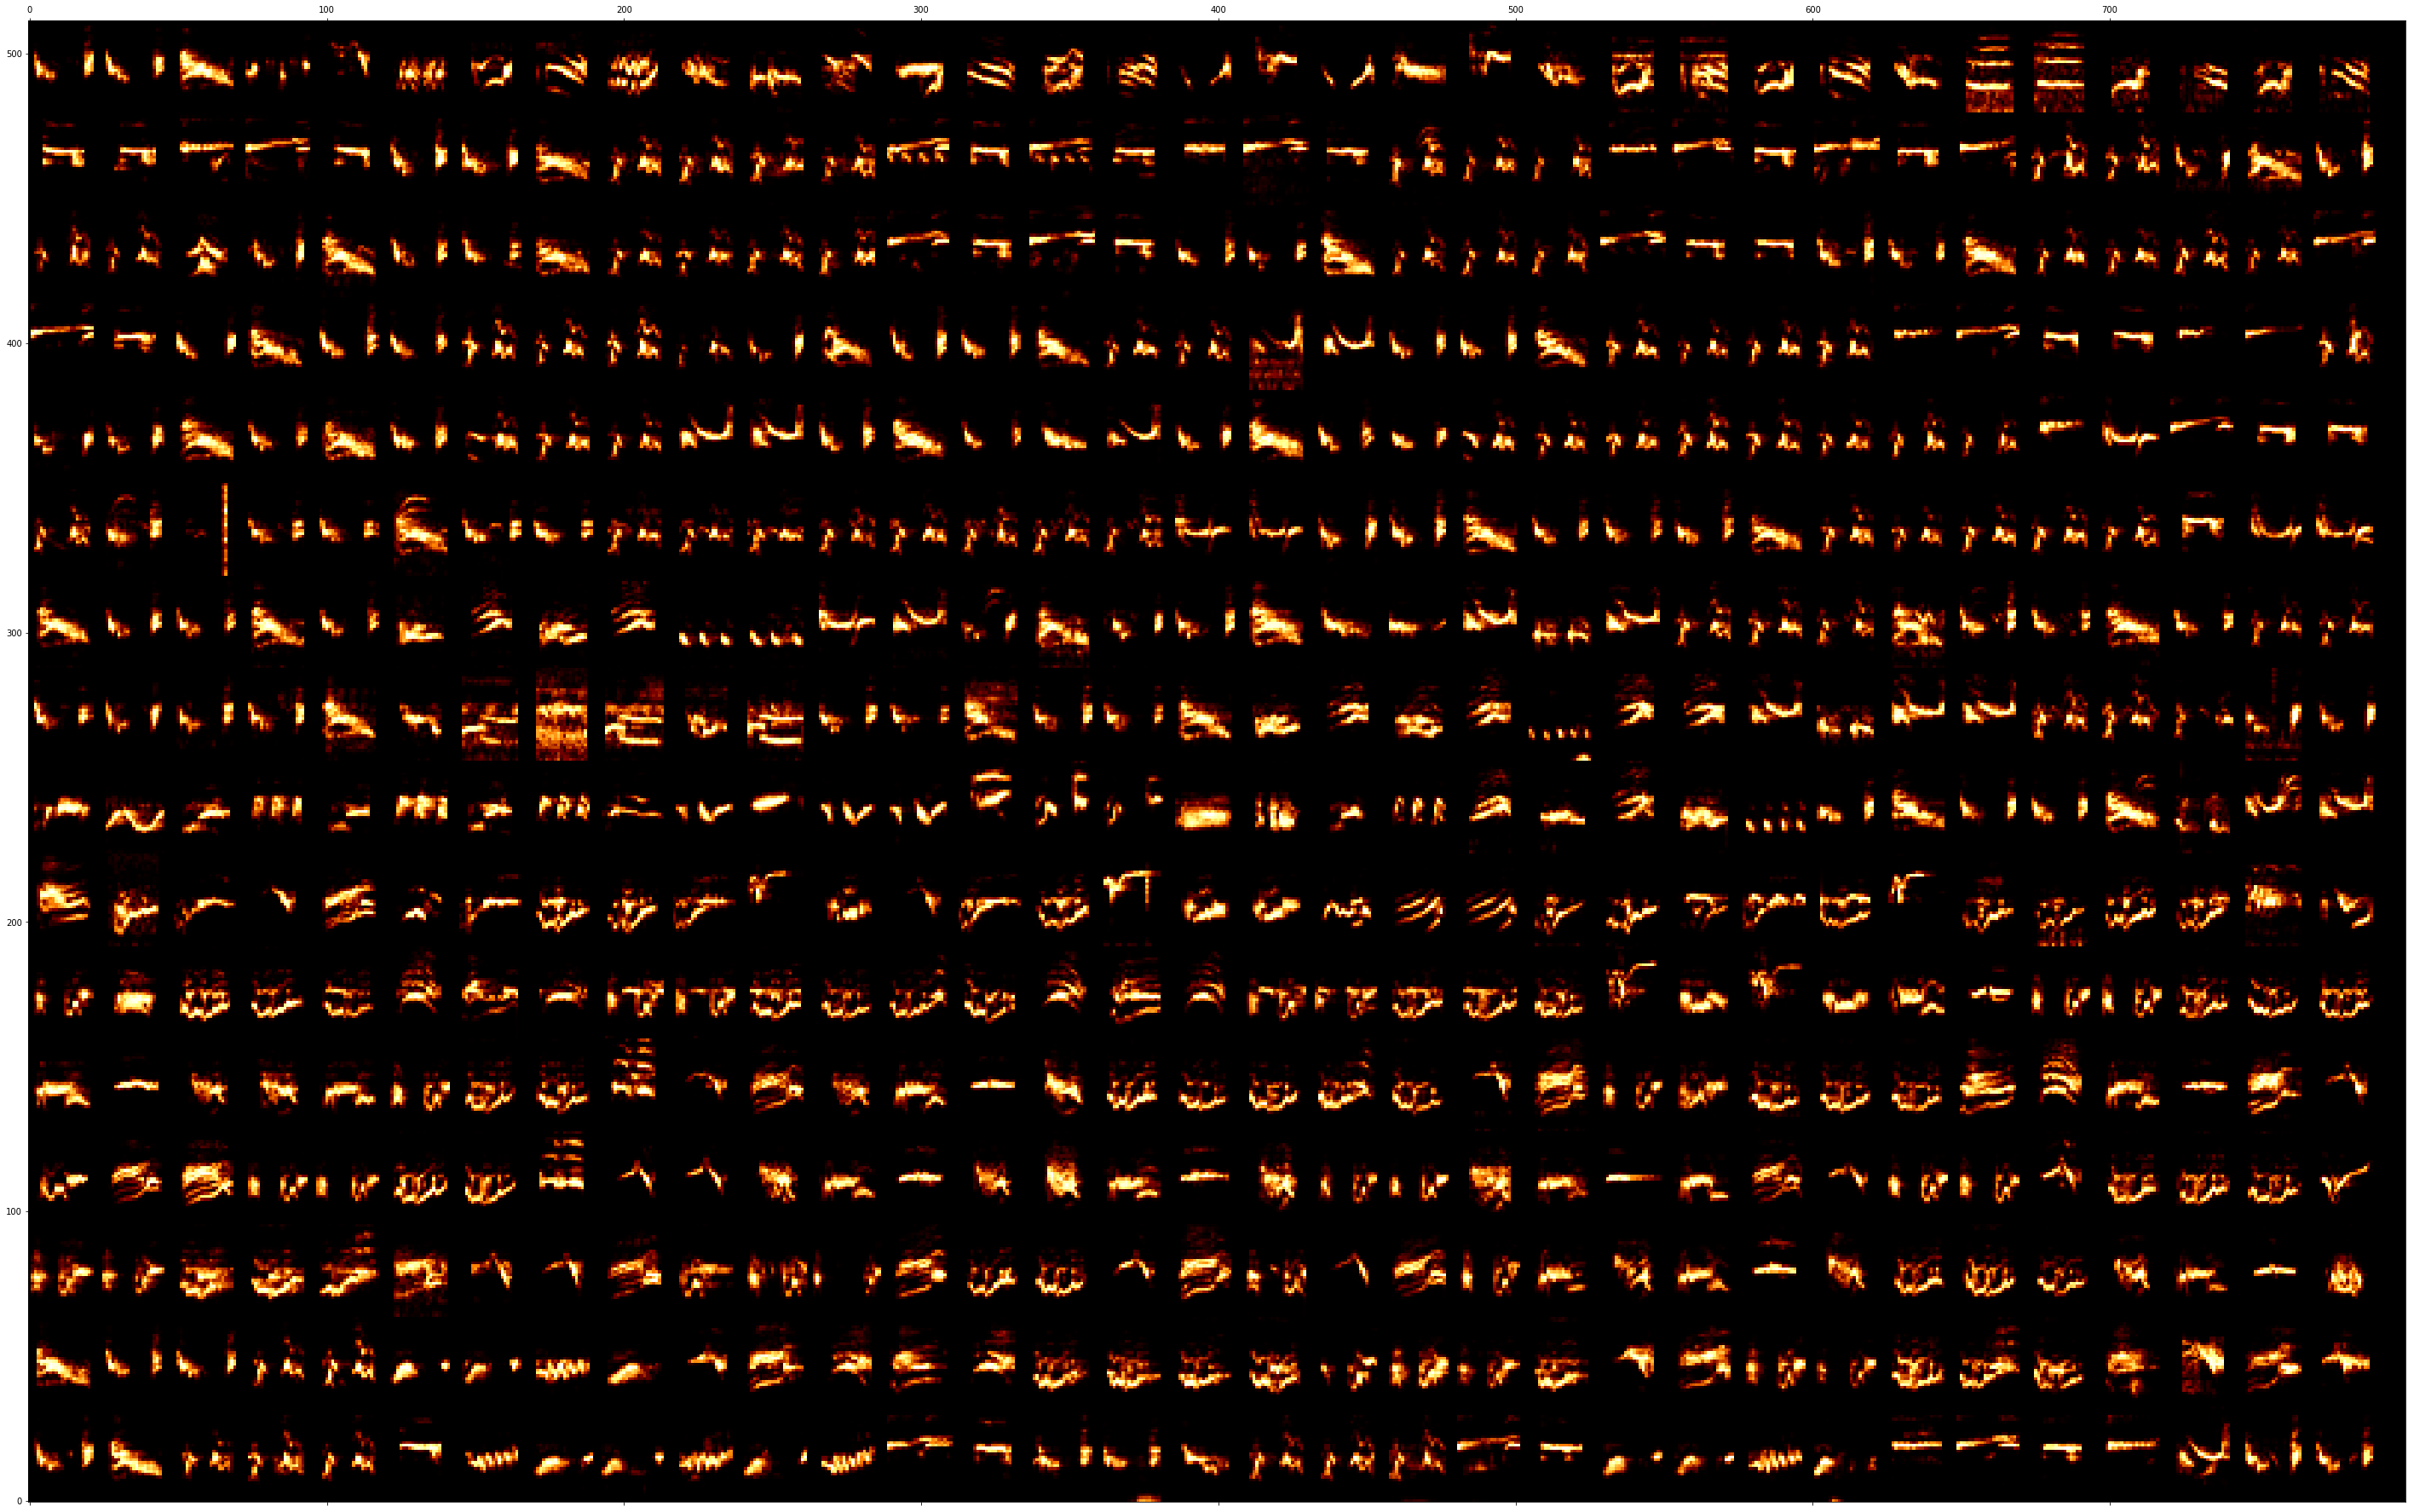

CATH-TLR8 2618
(50.0, 32) (512, 800) 25.0 32 800


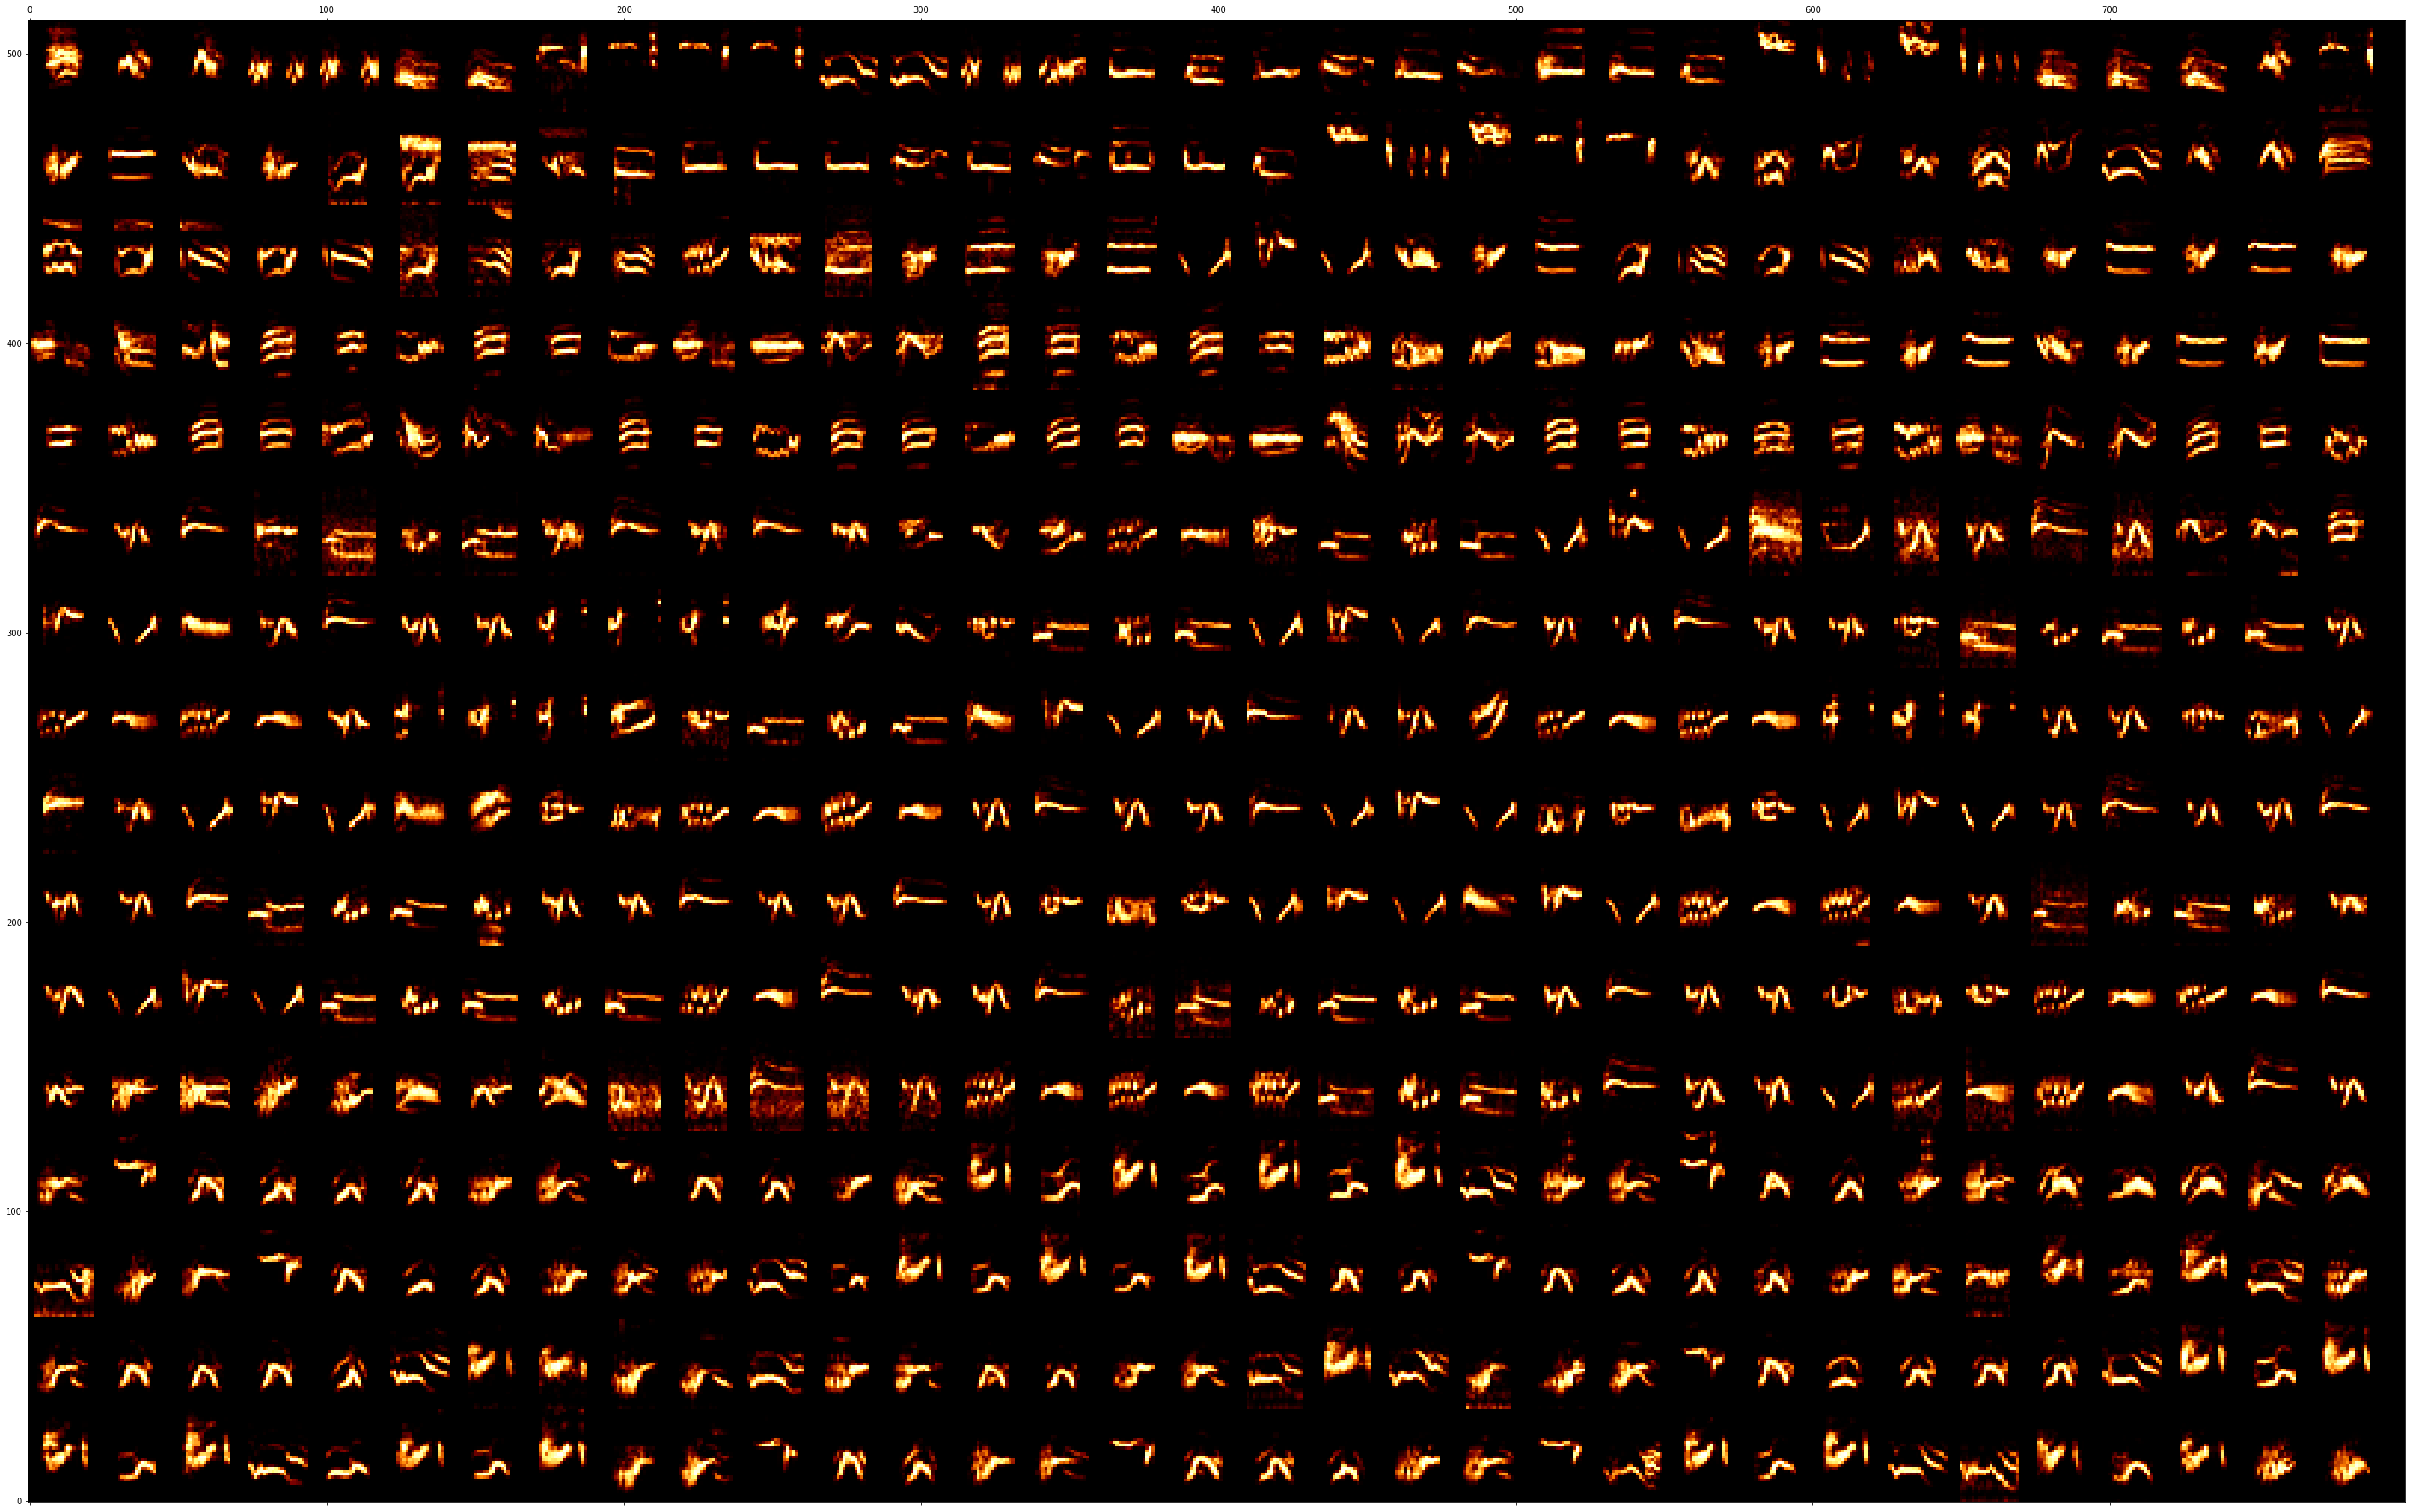

CATH-TLR9 1422
(50.0, 32) (512, 800) 25.0 32 800


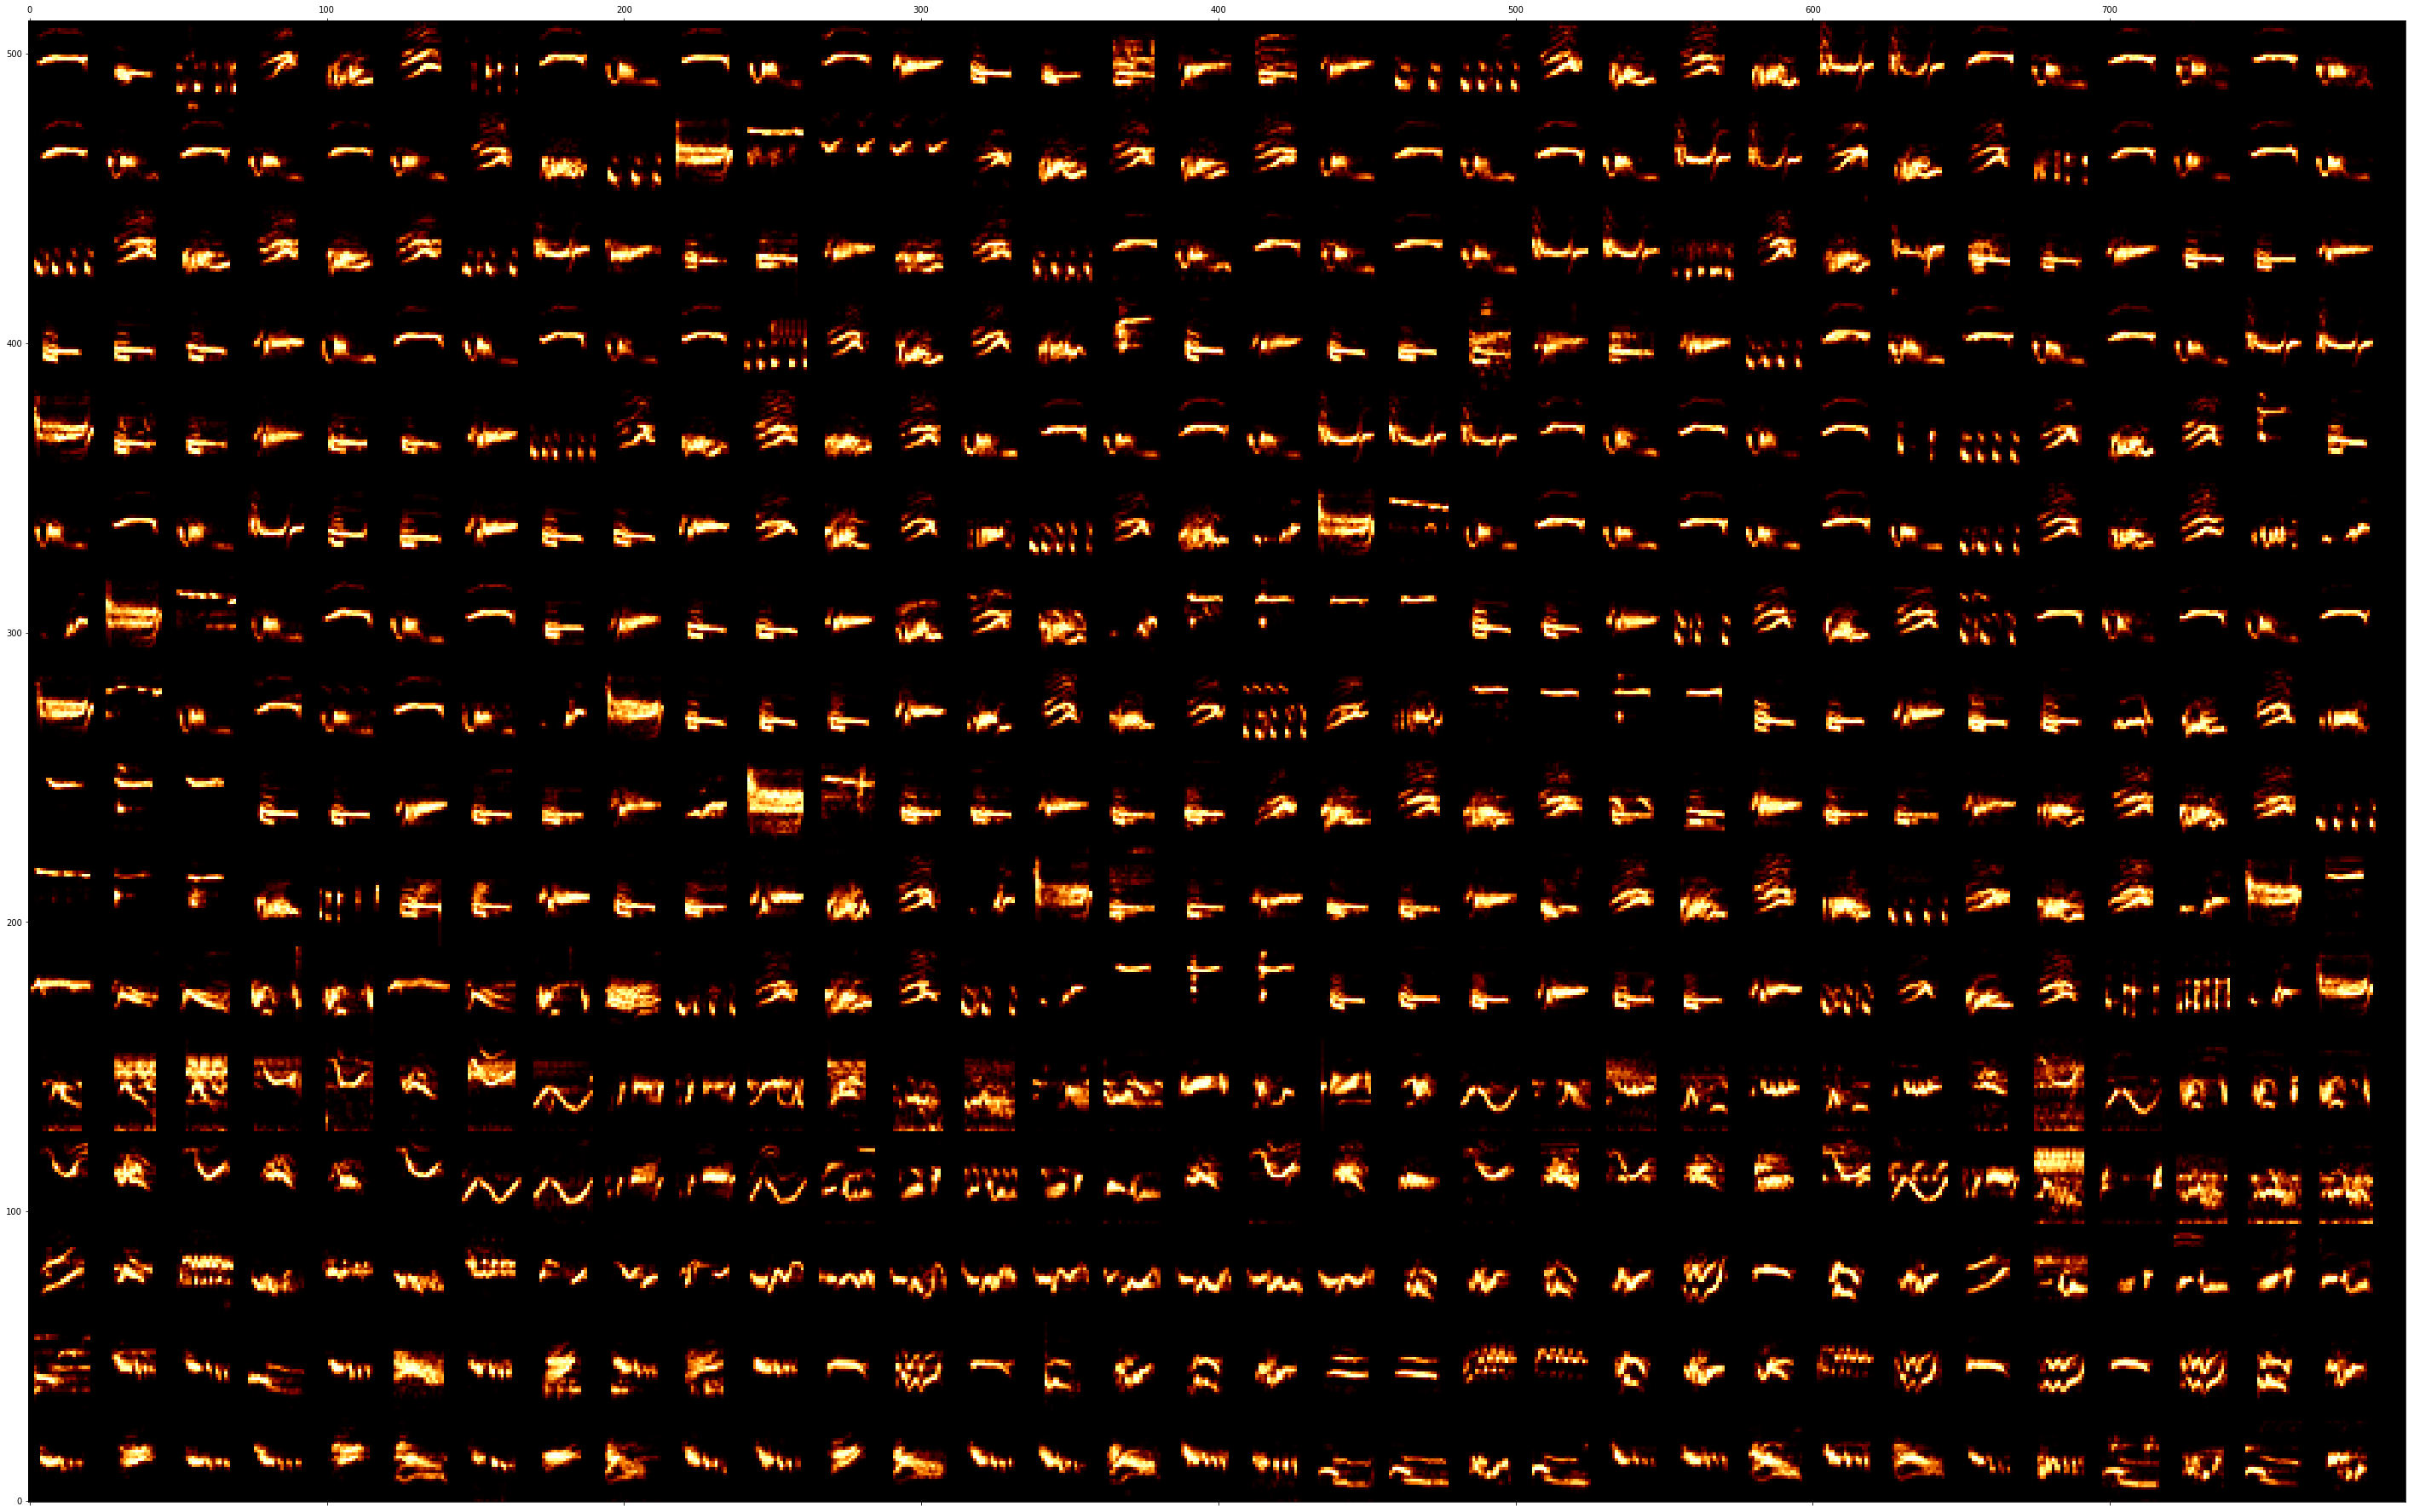

In [38]:
for indv in np.sort(syllable_df.indv.unique()):
    print(indv, np.sum(syllable_df.indv == indv))
    specs = np.array([i/np.max(i) for i in syllable_df[syllable_df.indv == indv].spectrogram.values])
    specs[specs<0] = 0
    draw_spec_set(specs, zoom=2,
                  maxrows=16, 
                  colsize=25)

### save dataset

In [40]:
save_loc = DATA_DIR / 'syllable_dfs' / DATASET_ID / 'thrasher.pickle'
ensure_dir(save_loc)
syllable_df.to_pickle(save_loc)